In [1]:
import time_series_model as model_ts
from time_series_model import Model_Forecast

import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
incidents = pd.read_csv('Incidents_treated.csv')

#incidents = pd.read_csv('../input/incidents-12h/Incidents_treated.csv')

incidents

,Number roads affected,Number of incidents
0,25,14
1,22,10
2,43,17
3,24,7
4,69,31
...,...,...
115,45,36
116,53,37
117,43,37
118,31,23


In [3]:
# [-1, 1] for LSTM due to internal use of tanh by the memory cell
scaler_f = MinMaxScaler(feature_range = (-1, 1))
scaler_target = MinMaxScaler(feature_range = (-1, 1))

f = 'Number roads affected'
t = 'Number of incidents'

incidents[[f]] = scaler_f.fit_transform(incidents[[f]])
incidents[[t]] = scaler_target.fit_transform(incidents[[t]])
incidents

,Number roads affected,Number of incidents
0,-0.972954,-0.987159
1,-0.977224,-0.993579
2,-0.947331,-0.982343
3,-0.974377,-0.998395
4,-0.910320,-0.959872
...,...,...
115,-0.944484,-0.951846
116,-0.933096,-0.950241
117,-0.947331,-0.950241
118,-0.964413,-0.972713


In [4]:
incidents = incidents.drop(columns = 'Number roads affected')
#incidents = incidents.drop(columns = 'Day has 12 hours')

In [5]:
#incidents = incidents.append(incidents, ignore_index = True)
#incidents = incidents.append(incidents, ignore_index = True)
#incidents

In [6]:
incidents = incidents[-24:].append(incidents[:-24])
incidents

,Number of incidents
96,-0.958266
97,-0.974318
98,-0.969502
99,-0.979133
100,-0.979133
...,...
91,-0.910112
92,-0.942215
93,-0.924559
94,-0.947030


In [7]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(incidents.columns)

# number of days to forecast - we will forecast the next 24 hours
MULTISTEPS = 24

# time series cross validator
CV_SPLITS = 15

EPOCHS = 1000

# 24 hours (1 day)
# 168 hours (7 days)
BATCH_SIZE = 48

In [8]:
# our supervised problem
x, y = model_ts.to_supervised(incidents[:-24], TIMESTEPS)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)


Training shape: (71, 24, 1)
Training labels shape: (71, 1, 1)


In [9]:
#final_model, rmse = model_ts.benchmarking(TIMESTEPS, FEATURES, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS, 
#                                    number_models_LSTM = 2, number_models_CNN = 0,
#                                    number_models_LSTM_Stateful = 0, number_models_GRU = 0,
#                                    number_models_CNN_LSTM = 0, number_models_MLP = 0)

In [10]:
final_model = tf.keras.Sequential()
final_model.add(tf.keras.layers.LSTM(128, 
                                   input_shape = (TIMESTEPS, FEATURES),
                                   return_sequences = True,
                                   activation = 'tanh'))
final_model.add(tf.keras.layers.BatchNormalization())
final_model.add(tf.keras.layers.Dropout(0.4))
final_model.add(tf.keras.layers.LSTM(128,
                                   return_sequences = True,
                                   activation = 'tanh'))
final_model.add(tf.keras.layers.BatchNormalization())
final_model.add(tf.keras.layers.Dropout(0.4))
final_model.add(tf.keras.layers.LSTM(32,
                                   return_sequences = True,
                                   activation = 'tanh'))
final_model.add(tf.keras.layers.BatchNormalization())
final_model.add(tf.keras.layers.Dropout(0.4))
final_model.add(tf.keras.layers.Dense(64,activation = 'tanh'))
final_model.add(tf.keras.layers.BatchNormalization())
final_model.add(tf.keras.layers.Dropout(0.5))
final_model.add(tf.keras.layers.Dense(FEATURES,activation = 'tanh'))


---------- Cross validation training model sequential ----------

Epoch 1/1000
1/1 - 9s - loss: 1.1499 - mae: 0.9193 - val_loss: 0.7144 - val_mae: 0.7136
Epoch 2/1000
1/1 - 0s - loss: 1.1874 - mae: 0.9585 - val_loss: 0.7174 - val_mae: 0.7169
Epoch 3/1000
1/1 - 0s - loss: 1.0465 - mae: 0.8047 - val_loss: 0.7221 - val_mae: 0.7216
Epoch 4/1000
1/1 - 0s - loss: 1.1147 - mae: 0.8706 - val_loss: 0.7216 - val_mae: 0.7210
Epoch 5/1000
1/1 - 0s - loss: 1.1072 - mae: 0.8553 - val_loss: 0.7171 - val_mae: 0.7163
Epoch 6/1000
1/1 - 0s - loss: 1.1002 - mae: 0.8641 - val_loss: 0.7131 - val_mae: 0.7121
Epoch 7/1000
1/1 - 0s - loss: 1.1789 - mae: 0.9456 - val_loss: 0.7069 - val_mae: 0.7057
Epoch 8/1000
1/1 - 0s - loss: 1.0790 - mae: 0.8216 - val_loss: 0.6952 - val_mae: 0.6940
Epoch 9/1000
1/1 - 0s - loss: 1.0122 - mae: 0.7852 - val_loss: 0.6806 - val_mae: 0.6794
Epoch 10/1000
1/1 - 0s - loss: 1.1086 - mae: 0.8532 - val_loss: 0.6632 - val_mae: 0.6621
Epoch 11/1000
1/1 - 0s - loss: 1.0608 - mae: 0.8003 

Epoch 93/1000
1/1 - 0s - loss: 0.7240 - mae: 0.5056 - val_loss: 0.0511 - val_mae: 0.0435
Epoch 94/1000
1/1 - 0s - loss: 0.7618 - mae: 0.5072 - val_loss: 0.0538 - val_mae: 0.0459
Epoch 95/1000
1/1 - 0s - loss: 0.6979 - mae: 0.4454 - val_loss: 0.0568 - val_mae: 0.0488
Epoch 96/1000
1/1 - 0s - loss: 0.7105 - mae: 0.4997 - val_loss: 0.0614 - val_mae: 0.0530
Epoch 97/1000
1/1 - 0s - loss: 0.6976 - mae: 0.4765 - val_loss: 0.0657 - val_mae: 0.0571
Epoch 98/1000
1/1 - 0s - loss: 0.7836 - mae: 0.5698 - val_loss: 0.0707 - val_mae: 0.0631
Epoch 99/1000
1/1 - 0s - loss: 0.7459 - mae: 0.5023 - val_loss: 0.0749 - val_mae: 0.0684
Epoch 100/1000
1/1 - 0s - loss: 0.6966 - mae: 0.4778 - val_loss: 0.0796 - val_mae: 0.0739
Epoch 101/1000
1/1 - 0s - loss: 0.7290 - mae: 0.5029 - val_loss: 0.0847 - val_mae: 0.0797
Epoch 102/1000
1/1 - 0s - loss: 0.6902 - mae: 0.4673 - val_loss: 0.0894 - val_mae: 0.0848
Epoch 103/1000
1/1 - 0s - loss: 0.6531 - mae: 0.4294 - val_loss: 0.0926 - val_mae: 0.0882
Epoch 104/1000
1/

Epoch 185/1000
1/1 - 0s - loss: 0.6309 - mae: 0.4178 - val_loss: 0.1422 - val_mae: 0.1388
Epoch 186/1000
1/1 - 0s - loss: 0.6648 - mae: 0.4636 - val_loss: 0.1426 - val_mae: 0.1392
Epoch 187/1000
1/1 - 0s - loss: 0.6815 - mae: 0.4554 - val_loss: 0.1430 - val_mae: 0.1396
Epoch 188/1000
1/1 - 0s - loss: 0.6735 - mae: 0.4654 - val_loss: 0.1432 - val_mae: 0.1398
Epoch 189/1000
1/1 - 0s - loss: 0.6955 - mae: 0.4495 - val_loss: 0.1437 - val_mae: 0.1403
Epoch 190/1000
1/1 - 0s - loss: 0.7064 - mae: 0.4911 - val_loss: 0.1441 - val_mae: 0.1407
Epoch 191/1000
1/1 - 0s - loss: 0.6570 - mae: 0.4246 - val_loss: 0.1443 - val_mae: 0.1409
Epoch 192/1000
1/1 - 0s - loss: 0.6336 - mae: 0.4159 - val_loss: 0.1448 - val_mae: 0.1414
Epoch 193/1000
1/1 - 0s - loss: 0.6744 - mae: 0.4648 - val_loss: 0.1452 - val_mae: 0.1418
Epoch 194/1000
1/1 - 0s - loss: 0.7137 - mae: 0.4720 - val_loss: 0.1456 - val_mae: 0.1423
Epoch 195/1000
1/1 - 0s - loss: 0.6809 - mae: 0.4693 - val_loss: 0.1460 - val_mae: 0.1426
Epoch 196/

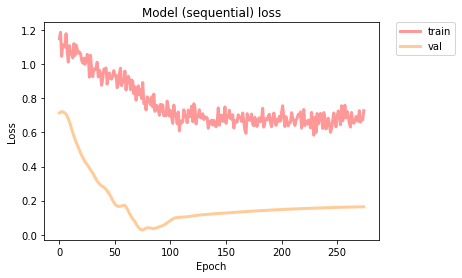

Epoch 1/1000
1/1 - 0s - loss: 0.7979 - mae: 0.5584 - val_loss: 0.1178 - val_mae: 0.1009
Epoch 2/1000
1/1 - 0s - loss: 0.8384 - mae: 0.5901 - val_loss: 0.1198 - val_mae: 0.1032
Epoch 3/1000
1/1 - 0s - loss: 0.8771 - mae: 0.6304 - val_loss: 0.1220 - val_mae: 0.1057
Epoch 4/1000
1/1 - 0s - loss: 0.8607 - mae: 0.6201 - val_loss: 0.1242 - val_mae: 0.1082
Epoch 5/1000
1/1 - 0s - loss: 0.8899 - mae: 0.6598 - val_loss: 0.1264 - val_mae: 0.1106
Epoch 6/1000
1/1 - 0s - loss: 0.8024 - mae: 0.5562 - val_loss: 0.1285 - val_mae: 0.1131
Epoch 7/1000
1/1 - 0s - loss: 0.7759 - mae: 0.5429 - val_loss: 0.1309 - val_mae: 0.1157
Epoch 8/1000
1/1 - 0s - loss: 0.8699 - mae: 0.6213 - val_loss: 0.1330 - val_mae: 0.1181
Epoch 9/1000
1/1 - 0s - loss: 0.8280 - mae: 0.5892 - val_loss: 0.1350 - val_mae: 0.1203
Epoch 10/1000
1/1 - 0s - loss: 0.8588 - mae: 0.6125 - val_loss: 0.1373 - val_mae: 0.1228
Epoch 11/1000
1/1 - 0s - loss: 0.8053 - mae: 0.5647 - val_loss: 0.1393 - val_mae: 0.1250
Epoch 12/1000
1/1 - 0s - loss:

1/1 - 0s - loss: 0.8705 - mae: 0.6308 - val_loss: 0.2583 - val_mae: 0.2499
Epoch 94/1000
1/1 - 0s - loss: 0.8154 - mae: 0.5779 - val_loss: 0.2590 - val_mae: 0.2506
Epoch 95/1000
1/1 - 0s - loss: 0.8470 - mae: 0.5990 - val_loss: 0.2597 - val_mae: 0.2513
Epoch 96/1000
1/1 - 0s - loss: 0.8817 - mae: 0.6508 - val_loss: 0.2603 - val_mae: 0.2519
Epoch 97/1000
1/1 - 0s - loss: 0.7616 - mae: 0.5382 - val_loss: 0.2608 - val_mae: 0.2525
Epoch 98/1000
1/1 - 0s - loss: 0.8233 - mae: 0.5857 - val_loss: 0.2614 - val_mae: 0.2531
Epoch 99/1000
1/1 - 0s - loss: 0.8937 - mae: 0.6478 - val_loss: 0.2621 - val_mae: 0.2538
Epoch 100/1000
1/1 - 0s - loss: 0.8409 - mae: 0.5938 - val_loss: 0.2627 - val_mae: 0.2545
Epoch 101/1000
1/1 - 0s - loss: 0.8129 - mae: 0.5902 - val_loss: 0.2634 - val_mae: 0.2552
Epoch 102/1000
1/1 - 0s - loss: 0.8353 - mae: 0.5851 - val_loss: 0.2641 - val_mae: 0.2558
Epoch 103/1000
1/1 - 0s - loss: 0.8170 - mae: 0.5840 - val_loss: 0.2647 - val_mae: 0.2565
Epoch 104/1000
1/1 - 0s - loss:

Epoch 185/1000
1/1 - 0s - loss: 0.8581 - mae: 0.6194 - val_loss: 0.2834 - val_mae: 0.2753
Epoch 186/1000
1/1 - 0s - loss: 0.8489 - mae: 0.6086 - val_loss: 0.2834 - val_mae: 0.2753
Epoch 187/1000
1/1 - 0s - loss: 0.8086 - mae: 0.5721 - val_loss: 0.2833 - val_mae: 0.2752
Epoch 188/1000
1/1 - 0s - loss: 0.8064 - mae: 0.5741 - val_loss: 0.2833 - val_mae: 0.2752
Epoch 189/1000
1/1 - 0s - loss: 0.8829 - mae: 0.6329 - val_loss: 0.2833 - val_mae: 0.2752
Epoch 190/1000
1/1 - 0s - loss: 0.8535 - mae: 0.6077 - val_loss: 0.2834 - val_mae: 0.2752
Epoch 191/1000
1/1 - 0s - loss: 0.8252 - mae: 0.5812 - val_loss: 0.2833 - val_mae: 0.2751
Epoch 192/1000
1/1 - 0s - loss: 0.8307 - mae: 0.5867 - val_loss: 0.2832 - val_mae: 0.2750
Epoch 193/1000
1/1 - 0s - loss: 0.7938 - mae: 0.5569 - val_loss: 0.2832 - val_mae: 0.2750
Epoch 194/1000
1/1 - 0s - loss: 0.7442 - mae: 0.5114 - val_loss: 0.2832 - val_mae: 0.2749
Epoch 195/1000
1/1 - 0s - loss: 0.8256 - mae: 0.5885 - val_loss: 0.2831 - val_mae: 0.2748
Epoch 196/

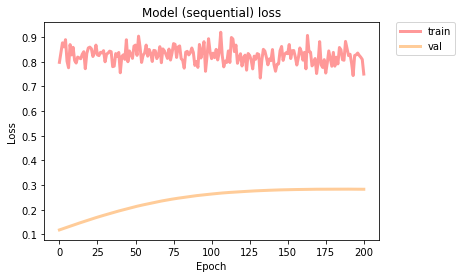

Epoch 1/1000
1/1 - 0s - loss: 0.8154 - mae: 0.5810 - val_loss: 0.3194 - val_mae: 0.2577
Epoch 2/1000
1/1 - 0s - loss: 0.8385 - mae: 0.6162 - val_loss: 0.3211 - val_mae: 0.2587
Epoch 3/1000
1/1 - 0s - loss: 0.8904 - mae: 0.6439 - val_loss: 0.3228 - val_mae: 0.2597
Epoch 4/1000
1/1 - 0s - loss: 0.8141 - mae: 0.5751 - val_loss: 0.3245 - val_mae: 0.2606
Epoch 5/1000
1/1 - 0s - loss: 0.8597 - mae: 0.6258 - val_loss: 0.3262 - val_mae: 0.2615
Epoch 6/1000
1/1 - 0s - loss: 0.8242 - mae: 0.5887 - val_loss: 0.3278 - val_mae: 0.2624
Epoch 7/1000
1/1 - 0s - loss: 0.7981 - mae: 0.5611 - val_loss: 0.3295 - val_mae: 0.2633
Epoch 8/1000
1/1 - 0s - loss: 0.8418 - mae: 0.6031 - val_loss: 0.3313 - val_mae: 0.2643
Epoch 9/1000
1/1 - 0s - loss: 0.8199 - mae: 0.5811 - val_loss: 0.3331 - val_mae: 0.2652
Epoch 10/1000
1/1 - 0s - loss: 0.8107 - mae: 0.5787 - val_loss: 0.3348 - val_mae: 0.2661
Epoch 11/1000
1/1 - 0s - loss: 0.7755 - mae: 0.5442 - val_loss: 0.3366 - val_mae: 0.2671
Epoch 12/1000
1/1 - 0s - loss:

Epoch 94/1000
1/1 - 0s - loss: 0.7811 - mae: 0.5438 - val_loss: 0.4301 - val_mae: 0.3431
Epoch 95/1000
1/1 - 0s - loss: 0.8201 - mae: 0.5859 - val_loss: 0.4306 - val_mae: 0.3436
Epoch 96/1000
1/1 - 0s - loss: 0.7694 - mae: 0.5488 - val_loss: 0.4310 - val_mae: 0.3441
Epoch 97/1000
1/1 - 0s - loss: 0.7903 - mae: 0.5546 - val_loss: 0.4315 - val_mae: 0.3447
Epoch 98/1000
1/1 - 0s - loss: 0.8498 - mae: 0.6233 - val_loss: 0.4320 - val_mae: 0.3452
Epoch 99/1000
1/1 - 0s - loss: 0.8252 - mae: 0.5777 - val_loss: 0.4323 - val_mae: 0.3456
Epoch 100/1000
1/1 - 0s - loss: 0.8062 - mae: 0.5669 - val_loss: 0.4327 - val_mae: 0.3460
Epoch 101/1000
1/1 - 0s - loss: 0.7935 - mae: 0.5601 - val_loss: 0.4331 - val_mae: 0.3465
Epoch 102/1000
1/1 - 0s - loss: 0.7955 - mae: 0.5492 - val_loss: 0.4335 - val_mae: 0.3470
Epoch 103/1000
1/1 - 0s - loss: 0.8311 - mae: 0.5884 - val_loss: 0.4338 - val_mae: 0.3474
Epoch 104/1000
1/1 - 0s - loss: 0.8479 - mae: 0.6058 - val_loss: 0.4341 - val_mae: 0.3477
Epoch 105/1000
1

Epoch 186/1000
1/1 - 0s - loss: 0.8551 - mae: 0.6134 - val_loss: 0.4446 - val_mae: 0.3598
Epoch 187/1000
1/1 - 0s - loss: 0.7888 - mae: 0.5523 - val_loss: 0.4445 - val_mae: 0.3597
Epoch 188/1000
1/1 - 0s - loss: 0.7863 - mae: 0.5637 - val_loss: 0.4445 - val_mae: 0.3596
Epoch 189/1000
1/1 - 0s - loss: 0.7900 - mae: 0.5586 - val_loss: 0.4444 - val_mae: 0.3595
Epoch 190/1000
1/1 - 0s - loss: 0.7951 - mae: 0.5718 - val_loss: 0.4444 - val_mae: 0.3594
Epoch 191/1000
1/1 - 0s - loss: 0.8562 - mae: 0.6304 - val_loss: 0.4443 - val_mae: 0.3593
Epoch 192/1000
1/1 - 0s - loss: 0.8098 - mae: 0.5805 - val_loss: 0.4442 - val_mae: 0.3592
Epoch 193/1000
1/1 - 0s - loss: 0.7835 - mae: 0.5617 - val_loss: 0.4441 - val_mae: 0.3591
Epoch 194/1000
1/1 - 0s - loss: 0.8011 - mae: 0.5713 - val_loss: 0.4441 - val_mae: 0.3590
Epoch 195/1000
1/1 - 0s - loss: 0.7771 - mae: 0.5604 - val_loss: 0.4440 - val_mae: 0.3590
Epoch 196/1000
1/1 - 0s - loss: 0.7956 - mae: 0.5674 - val_loss: 0.4440 - val_mae: 0.3589
Epoch 197/

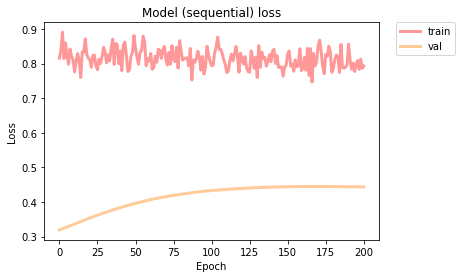

Epoch 1/1000
1/1 - 0s - loss: 0.8386 - mae: 0.6222 - val_loss: 0.1553 - val_mae: 0.1524
Epoch 2/1000
1/1 - 0s - loss: 0.7762 - mae: 0.5578 - val_loss: 0.1523 - val_mae: 0.1493
Epoch 3/1000
1/1 - 0s - loss: 0.8121 - mae: 0.5959 - val_loss: 0.1493 - val_mae: 0.1462
Epoch 4/1000
1/1 - 0s - loss: 0.8253 - mae: 0.6111 - val_loss: 0.1464 - val_mae: 0.1432
Epoch 5/1000
1/1 - 0s - loss: 0.8303 - mae: 0.6070 - val_loss: 0.1434 - val_mae: 0.1402
Epoch 6/1000
1/1 - 0s - loss: 0.8026 - mae: 0.5954 - val_loss: 0.1408 - val_mae: 0.1374
Epoch 7/1000
1/1 - 0s - loss: 0.7932 - mae: 0.5782 - val_loss: 0.1379 - val_mae: 0.1344
Epoch 8/1000
1/1 - 0s - loss: 0.7783 - mae: 0.5611 - val_loss: 0.1352 - val_mae: 0.1316
Epoch 9/1000
1/1 - 0s - loss: 0.8348 - mae: 0.6113 - val_loss: 0.1323 - val_mae: 0.1286
Epoch 10/1000
1/1 - 0s - loss: 0.8127 - mae: 0.5904 - val_loss: 0.1295 - val_mae: 0.1256
Epoch 11/1000
1/1 - 0s - loss: 0.8058 - mae: 0.5960 - val_loss: 0.1267 - val_mae: 0.1228
Epoch 12/1000
1/1 - 0s - loss:

1/1 - 0s - loss: 0.7691 - mae: 0.5721 - val_loss: 0.0349 - val_mae: 0.0273
Epoch 94/1000
1/1 - 0s - loss: 0.8443 - mae: 0.6232 - val_loss: 0.0348 - val_mae: 0.0273
Epoch 95/1000
1/1 - 0s - loss: 0.8020 - mae: 0.5866 - val_loss: 0.0347 - val_mae: 0.0272
Epoch 96/1000
1/1 - 0s - loss: 0.7564 - mae: 0.5427 - val_loss: 0.0346 - val_mae: 0.0272
Epoch 97/1000
1/1 - 0s - loss: 0.8312 - mae: 0.6119 - val_loss: 0.0345 - val_mae: 0.0272
Epoch 98/1000
1/1 - 0s - loss: 0.8022 - mae: 0.5923 - val_loss: 0.0345 - val_mae: 0.0272
Epoch 99/1000
1/1 - 0s - loss: 0.8143 - mae: 0.5931 - val_loss: 0.0344 - val_mae: 0.0272
Epoch 100/1000
1/1 - 0s - loss: 0.8116 - mae: 0.5884 - val_loss: 0.0344 - val_mae: 0.0272
Epoch 101/1000
1/1 - 0s - loss: 0.8037 - mae: 0.5978 - val_loss: 0.0344 - val_mae: 0.0272
Epoch 102/1000
1/1 - 0s - loss: 0.7919 - mae: 0.5753 - val_loss: 0.0344 - val_mae: 0.0273
Epoch 103/1000
1/1 - 0s - loss: 0.7982 - mae: 0.5826 - val_loss: 0.0343 - val_mae: 0.0273
Epoch 104/1000
1/1 - 0s - loss:

Epoch 185/1000
1/1 - 0s - loss: 0.7719 - mae: 0.5669 - val_loss: 0.0380 - val_mae: 0.0326
Epoch 186/1000
1/1 - 0s - loss: 0.8211 - mae: 0.6129 - val_loss: 0.0381 - val_mae: 0.0327
Epoch 187/1000
1/1 - 0s - loss: 0.7908 - mae: 0.5805 - val_loss: 0.0382 - val_mae: 0.0328
Epoch 188/1000
1/1 - 0s - loss: 0.7781 - mae: 0.5691 - val_loss: 0.0383 - val_mae: 0.0329
Epoch 189/1000
1/1 - 0s - loss: 0.8261 - mae: 0.6106 - val_loss: 0.0384 - val_mae: 0.0330
Epoch 190/1000
1/1 - 0s - loss: 0.7824 - mae: 0.5713 - val_loss: 0.0385 - val_mae: 0.0331
Epoch 191/1000
1/1 - 0s - loss: 0.7168 - mae: 0.5198 - val_loss: 0.0386 - val_mae: 0.0332
Epoch 192/1000
1/1 - 0s - loss: 0.7759 - mae: 0.5773 - val_loss: 0.0387 - val_mae: 0.0334
Epoch 193/1000
1/1 - 0s - loss: 0.8041 - mae: 0.5834 - val_loss: 0.0388 - val_mae: 0.0335
Epoch 194/1000
1/1 - 0s - loss: 0.7649 - mae: 0.5551 - val_loss: 0.0389 - val_mae: 0.0336
Epoch 195/1000
1/1 - 0s - loss: 0.7953 - mae: 0.5861 - val_loss: 0.0391 - val_mae: 0.0337
Epoch 196/

Epoch 277/1000
1/1 - 0s - loss: 0.8074 - mae: 0.5960 - val_loss: 0.0559 - val_mae: 0.0471
Epoch 278/1000
1/1 - 0s - loss: 0.7825 - mae: 0.5717 - val_loss: 0.0562 - val_mae: 0.0474
Epoch 279/1000
1/1 - 0s - loss: 0.7953 - mae: 0.5722 - val_loss: 0.0565 - val_mae: 0.0476
Epoch 280/1000
1/1 - 0s - loss: 0.7616 - mae: 0.5586 - val_loss: 0.0569 - val_mae: 0.0479
Epoch 281/1000
1/1 - 0s - loss: 0.7666 - mae: 0.5593 - val_loss: 0.0572 - val_mae: 0.0482
Epoch 282/1000
1/1 - 0s - loss: 0.8021 - mae: 0.5839 - val_loss: 0.0575 - val_mae: 0.0484
Epoch 283/1000
1/1 - 0s - loss: 0.7612 - mae: 0.5668 - val_loss: 0.0578 - val_mae: 0.0487
Epoch 284/1000
1/1 - 0s - loss: 0.7314 - mae: 0.5270 - val_loss: 0.0581 - val_mae: 0.0489
Epoch 285/1000
1/1 - 0s - loss: 0.7848 - mae: 0.5659 - val_loss: 0.0583 - val_mae: 0.0491
Epoch 286/1000
1/1 - 0s - loss: 0.7795 - mae: 0.5716 - val_loss: 0.0587 - val_mae: 0.0493
Epoch 287/1000
1/1 - 0s - loss: 0.8153 - mae: 0.5961 - val_loss: 0.0590 - val_mae: 0.0496
Epoch 288/

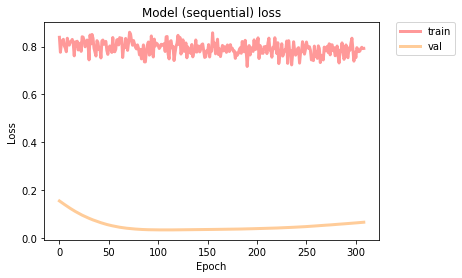

Epoch 1/1000
1/1 - 0s - loss: 0.7709 - mae: 0.5460 - val_loss: 0.0537 - val_mae: 0.0439
Epoch 2/1000
1/1 - 0s - loss: 0.8224 - mae: 0.5958 - val_loss: 0.0535 - val_mae: 0.0437
Epoch 3/1000
1/1 - 0s - loss: 0.8199 - mae: 0.5980 - val_loss: 0.0533 - val_mae: 0.0435
Epoch 4/1000
1/1 - 0s - loss: 0.8154 - mae: 0.6004 - val_loss: 0.0530 - val_mae: 0.0433
Epoch 5/1000
1/1 - 0s - loss: 0.8031 - mae: 0.5815 - val_loss: 0.0528 - val_mae: 0.0431
Epoch 6/1000
1/1 - 0s - loss: 0.8110 - mae: 0.5851 - val_loss: 0.0527 - val_mae: 0.0430
Epoch 7/1000
1/1 - 0s - loss: 0.7966 - mae: 0.5766 - val_loss: 0.0525 - val_mae: 0.0428
Epoch 8/1000
1/1 - 0s - loss: 0.8091 - mae: 0.5793 - val_loss: 0.0523 - val_mae: 0.0426
Epoch 9/1000
1/1 - 0s - loss: 0.7953 - mae: 0.5755 - val_loss: 0.0521 - val_mae: 0.0425
Epoch 10/1000
1/1 - 0s - loss: 0.8221 - mae: 0.6001 - val_loss: 0.0521 - val_mae: 0.0425
Epoch 11/1000
1/1 - 0s - loss: 0.7881 - mae: 0.5679 - val_loss: 0.0520 - val_mae: 0.0424
Epoch 12/1000
1/1 - 0s - loss:

1/1 - 0s - loss: 0.7853 - mae: 0.5576 - val_loss: 0.0653 - val_mae: 0.0544
Epoch 94/1000
1/1 - 0s - loss: 0.7819 - mae: 0.5557 - val_loss: 0.0658 - val_mae: 0.0549
Epoch 95/1000
1/1 - 0s - loss: 0.7689 - mae: 0.5536 - val_loss: 0.0663 - val_mae: 0.0553
Epoch 96/1000
1/1 - 0s - loss: 0.7535 - mae: 0.5363 - val_loss: 0.0668 - val_mae: 0.0558
Epoch 97/1000
1/1 - 0s - loss: 0.7978 - mae: 0.5737 - val_loss: 0.0673 - val_mae: 0.0562
Epoch 98/1000
1/1 - 0s - loss: 0.7900 - mae: 0.5818 - val_loss: 0.0678 - val_mae: 0.0567
Epoch 99/1000
1/1 - 0s - loss: 0.7710 - mae: 0.5458 - val_loss: 0.0683 - val_mae: 0.0572
Epoch 100/1000
1/1 - 0s - loss: 0.8161 - mae: 0.5911 - val_loss: 0.0688 - val_mae: 0.0576
Epoch 101/1000
1/1 - 0s - loss: 0.7786 - mae: 0.5597 - val_loss: 0.0693 - val_mae: 0.0581
Epoch 102/1000
1/1 - 0s - loss: 0.7871 - mae: 0.5610 - val_loss: 0.0698 - val_mae: 0.0585
Epoch 103/1000
1/1 - 0s - loss: 0.7975 - mae: 0.5774 - val_loss: 0.0704 - val_mae: 0.0590
Epoch 104/1000
1/1 - 0s - loss:

Epoch 185/1000
1/1 - 0s - loss: 0.7916 - mae: 0.5743 - val_loss: 0.1222 - val_mae: 0.1081
Epoch 186/1000
1/1 - 0s - loss: 0.8558 - mae: 0.6259 - val_loss: 0.1228 - val_mae: 0.1088
Epoch 187/1000
1/1 - 0s - loss: 0.7702 - mae: 0.5522 - val_loss: 0.1236 - val_mae: 0.1095
Epoch 188/1000
1/1 - 0s - loss: 0.7883 - mae: 0.5608 - val_loss: 0.1245 - val_mae: 0.1104
Epoch 189/1000
1/1 - 0s - loss: 0.7937 - mae: 0.5732 - val_loss: 0.1255 - val_mae: 0.1114
Epoch 190/1000
1/1 - 0s - loss: 0.8101 - mae: 0.5853 - val_loss: 0.1263 - val_mae: 0.1122
Epoch 191/1000
1/1 - 0s - loss: 0.7583 - mae: 0.5446 - val_loss: 0.1270 - val_mae: 0.1129
Epoch 192/1000
1/1 - 0s - loss: 0.7957 - mae: 0.5753 - val_loss: 0.1277 - val_mae: 0.1137
Epoch 193/1000
1/1 - 0s - loss: 0.8114 - mae: 0.5981 - val_loss: 0.1287 - val_mae: 0.1146
Epoch 194/1000
1/1 - 0s - loss: 0.7683 - mae: 0.5571 - val_loss: 0.1296 - val_mae: 0.1155
Epoch 195/1000
1/1 - 0s - loss: 0.8167 - mae: 0.6009 - val_loss: 0.1304 - val_mae: 0.1163
Epoch 196/

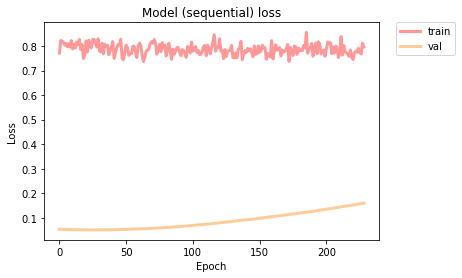

Epoch 1/1000
1/1 - 0s - loss: 0.8029 - mae: 0.5726 - val_loss: 0.5308 - val_mae: 0.2674
Epoch 2/1000
1/1 - 0s - loss: 0.8402 - mae: 0.6051 - val_loss: 0.5308 - val_mae: 0.2674
Epoch 3/1000
1/1 - 0s - loss: 0.8188 - mae: 0.5711 - val_loss: 0.5307 - val_mae: 0.2674
Epoch 4/1000
1/1 - 0s - loss: 0.7998 - mae: 0.5805 - val_loss: 0.5306 - val_mae: 0.2673
Epoch 5/1000
1/1 - 0s - loss: 0.7810 - mae: 0.5541 - val_loss: 0.5305 - val_mae: 0.2673
Epoch 6/1000
1/1 - 0s - loss: 0.7841 - mae: 0.5541 - val_loss: 0.5304 - val_mae: 0.2673
Epoch 7/1000
1/1 - 0s - loss: 0.8161 - mae: 0.5784 - val_loss: 0.5303 - val_mae: 0.2673
Epoch 8/1000
1/1 - 0s - loss: 0.8267 - mae: 0.5837 - val_loss: 0.5302 - val_mae: 0.2673
Epoch 9/1000
1/1 - 0s - loss: 0.8096 - mae: 0.5722 - val_loss: 0.5301 - val_mae: 0.2672
Epoch 10/1000
1/1 - 0s - loss: 0.8306 - mae: 0.5877 - val_loss: 0.5300 - val_mae: 0.2672
Epoch 11/1000
1/1 - 0s - loss: 0.8468 - mae: 0.6211 - val_loss: 0.5299 - val_mae: 0.2672
Epoch 12/1000
1/1 - 0s - loss:

1/1 - 0s - loss: 0.7817 - mae: 0.5543 - val_loss: 0.5150 - val_mae: 0.2752
Epoch 94/1000
1/1 - 0s - loss: 0.7710 - mae: 0.5415 - val_loss: 0.5148 - val_mae: 0.2755
Epoch 95/1000
1/1 - 0s - loss: 0.7794 - mae: 0.5415 - val_loss: 0.5146 - val_mae: 0.2757
Epoch 96/1000
1/1 - 0s - loss: 0.7733 - mae: 0.5400 - val_loss: 0.5144 - val_mae: 0.2759
Epoch 97/1000
1/1 - 0s - loss: 0.7492 - mae: 0.5115 - val_loss: 0.5143 - val_mae: 0.2761
Epoch 98/1000
1/1 - 0s - loss: 0.7779 - mae: 0.5479 - val_loss: 0.5141 - val_mae: 0.2764
Epoch 99/1000
1/1 - 0s - loss: 0.7779 - mae: 0.5410 - val_loss: 0.5139 - val_mae: 0.2766
Epoch 100/1000
1/1 - 0s - loss: 0.8170 - mae: 0.5744 - val_loss: 0.5137 - val_mae: 0.2768
Epoch 101/1000
1/1 - 0s - loss: 0.8202 - mae: 0.5943 - val_loss: 0.5136 - val_mae: 0.2770
Epoch 102/1000
1/1 - 0s - loss: 0.8252 - mae: 0.5894 - val_loss: 0.5134 - val_mae: 0.2773
Epoch 103/1000
1/1 - 0s - loss: 0.7922 - mae: 0.5509 - val_loss: 0.5132 - val_mae: 0.2776
Epoch 104/1000
1/1 - 0s - loss:

Epoch 185/1000
1/1 - 0s - loss: 0.7897 - mae: 0.5643 - val_loss: 0.4983 - val_mae: 0.3092
Epoch 186/1000
1/1 - 0s - loss: 0.7845 - mae: 0.5621 - val_loss: 0.4981 - val_mae: 0.3098
Epoch 187/1000
1/1 - 0s - loss: 0.7885 - mae: 0.5622 - val_loss: 0.4980 - val_mae: 0.3104
Epoch 188/1000
1/1 - 0s - loss: 0.7977 - mae: 0.5607 - val_loss: 0.4978 - val_mae: 0.3110
Epoch 189/1000
1/1 - 0s - loss: 0.7958 - mae: 0.5621 - val_loss: 0.4977 - val_mae: 0.3115
Epoch 190/1000
1/1 - 0s - loss: 0.7355 - mae: 0.5136 - val_loss: 0.4976 - val_mae: 0.3122
Epoch 191/1000
1/1 - 0s - loss: 0.7688 - mae: 0.5354 - val_loss: 0.4974 - val_mae: 0.3129
Epoch 192/1000
1/1 - 0s - loss: 0.8211 - mae: 0.5991 - val_loss: 0.4973 - val_mae: 0.3135
Epoch 193/1000
1/1 - 0s - loss: 0.7951 - mae: 0.5612 - val_loss: 0.4972 - val_mae: 0.3141
Epoch 194/1000
1/1 - 0s - loss: 0.7938 - mae: 0.5611 - val_loss: 0.4971 - val_mae: 0.3148
Epoch 195/1000
1/1 - 0s - loss: 0.7602 - mae: 0.5419 - val_loss: 0.4970 - val_mae: 0.3154
Epoch 196/

1/1 - 0s - loss: 0.8110 - mae: 0.5919 - val_loss: 0.4947 - val_mae: 0.3612
Epoch 277/1000
1/1 - 0s - loss: 0.7658 - mae: 0.5450 - val_loss: 0.4948 - val_mae: 0.3619
Epoch 278/1000
1/1 - 0s - loss: 0.7810 - mae: 0.5522 - val_loss: 0.4948 - val_mae: 0.3626
Epoch 279/1000
1/1 - 0s - loss: 0.7916 - mae: 0.5622 - val_loss: 0.4949 - val_mae: 0.3633
Epoch 280/1000
1/1 - 0s - loss: 0.7547 - mae: 0.5274 - val_loss: 0.4949 - val_mae: 0.3639
Epoch 281/1000
1/1 - 0s - loss: 0.7627 - mae: 0.5398 - val_loss: 0.4949 - val_mae: 0.3643
Epoch 282/1000
1/1 - 0s - loss: 0.7338 - mae: 0.5184 - val_loss: 0.4949 - val_mae: 0.3649
Epoch 283/1000
1/1 - 0s - loss: 0.7432 - mae: 0.5282 - val_loss: 0.4950 - val_mae: 0.3655
Epoch 284/1000
1/1 - 0s - loss: 0.7923 - mae: 0.5697 - val_loss: 0.4950 - val_mae: 0.3661
Epoch 285/1000
1/1 - 0s - loss: 0.7602 - mae: 0.5436 - val_loss: 0.4950 - val_mae: 0.3665
Epoch 286/1000
1/1 - 0s - loss: 0.8179 - mae: 0.5913 - val_loss: 0.4950 - val_mae: 0.3670
Epoch 287/1000
1/1 - 0s -

Epoch 368/1000
1/1 - 0s - loss: 0.7809 - mae: 0.5463 - val_loss: 0.4937 - val_mae: 0.4055
Epoch 369/1000
1/1 - 0s - loss: 0.7636 - mae: 0.5408 - val_loss: 0.4938 - val_mae: 0.4061
Epoch 370/1000
1/1 - 0s - loss: 0.7465 - mae: 0.5382 - val_loss: 0.4940 - val_mae: 0.4066
Epoch 371/1000
1/1 - 0s - loss: 0.7670 - mae: 0.5458 - val_loss: 0.4942 - val_mae: 0.4073
Epoch 372/1000
1/1 - 0s - loss: 0.7781 - mae: 0.5584 - val_loss: 0.4944 - val_mae: 0.4080
Epoch 373/1000
1/1 - 0s - loss: 0.7681 - mae: 0.5395 - val_loss: 0.4945 - val_mae: 0.4086
Epoch 374/1000
1/1 - 0s - loss: 0.7511 - mae: 0.5292 - val_loss: 0.4946 - val_mae: 0.4090
Epoch 375/1000
1/1 - 0s - loss: 0.7785 - mae: 0.5568 - val_loss: 0.4948 - val_mae: 0.4096
Epoch 376/1000
1/1 - 0s - loss: 0.7510 - mae: 0.5231 - val_loss: 0.4951 - val_mae: 0.4104
Epoch 377/1000
1/1 - 0s - loss: 0.7349 - mae: 0.5116 - val_loss: 0.4952 - val_mae: 0.4109
Epoch 378/1000
1/1 - 0s - loss: 0.7936 - mae: 0.5794 - val_loss: 0.4954 - val_mae: 0.4114
Epoch 379/

1/1 - 0s - loss: 0.7494 - mae: 0.5273 - val_loss: 0.5064 - val_mae: 0.4373
Epoch 460/1000
1/1 - 0s - loss: 0.7384 - mae: 0.5106 - val_loss: 0.5067 - val_mae: 0.4377
Epoch 461/1000
1/1 - 0s - loss: 0.7699 - mae: 0.5560 - val_loss: 0.5070 - val_mae: 0.4382
Epoch 462/1000
1/1 - 0s - loss: 0.7612 - mae: 0.5427 - val_loss: 0.5073 - val_mae: 0.4387
Epoch 463/1000
1/1 - 0s - loss: 0.7908 - mae: 0.5592 - val_loss: 0.5076 - val_mae: 0.4390
Epoch 464/1000
1/1 - 0s - loss: 0.7752 - mae: 0.5566 - val_loss: 0.5078 - val_mae: 0.4394
Epoch 465/1000
1/1 - 0s - loss: 0.7696 - mae: 0.5455 - val_loss: 0.5079 - val_mae: 0.4395
Epoch 466/1000
1/1 - 0s - loss: 0.7710 - mae: 0.5529 - val_loss: 0.5083 - val_mae: 0.4401
Epoch 467/1000
1/1 - 0s - loss: 0.7841 - mae: 0.5541 - val_loss: 0.5085 - val_mae: 0.4405
Epoch 468/1000
1/1 - 0s - loss: 0.7743 - mae: 0.5427 - val_loss: 0.5088 - val_mae: 0.4409
Epoch 469/1000
1/1 - 0s - loss: 0.7644 - mae: 0.5430 - val_loss: 0.5091 - val_mae: 0.4414
Epoch 470/1000
1/1 - 0s -

Epoch 551/1000
1/1 - 0s - loss: 0.7712 - mae: 0.5504 - val_loss: 0.5205 - val_mae: 0.4601
Epoch 552/1000
1/1 - 0s - loss: 0.7600 - mae: 0.5428 - val_loss: 0.5206 - val_mae: 0.4602
Epoch 553/1000
1/1 - 0s - loss: 0.7505 - mae: 0.5274 - val_loss: 0.5206 - val_mae: 0.4604
dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])


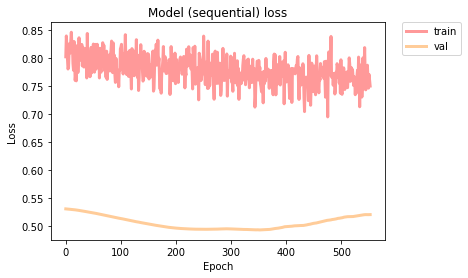

Epoch 1/1000
1/1 - 0s - loss: 0.7758 - mae: 0.5389 - val_loss: 0.4731 - val_mae: 0.3536
Epoch 2/1000
1/1 - 0s - loss: 0.7920 - mae: 0.5638 - val_loss: 0.4730 - val_mae: 0.3538
Epoch 3/1000
1/1 - 0s - loss: 0.8211 - mae: 0.5829 - val_loss: 0.4730 - val_mae: 0.3540
Epoch 4/1000
1/1 - 0s - loss: 0.7461 - mae: 0.5259 - val_loss: 0.4730 - val_mae: 0.3541
Epoch 5/1000
1/1 - 0s - loss: 0.7735 - mae: 0.5447 - val_loss: 0.4729 - val_mae: 0.3542
Epoch 6/1000
1/1 - 0s - loss: 0.8017 - mae: 0.5722 - val_loss: 0.4729 - val_mae: 0.3544
Epoch 7/1000
1/1 - 0s - loss: 0.7532 - mae: 0.5209 - val_loss: 0.4729 - val_mae: 0.3545
Epoch 8/1000
1/1 - 0s - loss: 0.7679 - mae: 0.5415 - val_loss: 0.4729 - val_mae: 0.3548
Epoch 9/1000
1/1 - 0s - loss: 0.8030 - mae: 0.5662 - val_loss: 0.4729 - val_mae: 0.3549
Epoch 10/1000
1/1 - 0s - loss: 0.7784 - mae: 0.5416 - val_loss: 0.4731 - val_mae: 0.3550
Epoch 11/1000
1/1 - 0s - loss: 0.7807 - mae: 0.5526 - val_loss: 0.4731 - val_mae: 0.3551
Epoch 12/1000
1/1 - 0s - loss:

1/1 - 0s - loss: 0.7465 - mae: 0.5142 - val_loss: 0.4942 - val_mae: 0.3783
Epoch 94/1000
1/1 - 0s - loss: 0.8133 - mae: 0.5704 - val_loss: 0.4944 - val_mae: 0.3785
Epoch 95/1000
1/1 - 0s - loss: 0.7773 - mae: 0.5520 - val_loss: 0.4946 - val_mae: 0.3787
Epoch 96/1000
1/1 - 0s - loss: 0.7754 - mae: 0.5479 - val_loss: 0.4948 - val_mae: 0.3789
Epoch 97/1000
1/1 - 0s - loss: 0.7906 - mae: 0.5547 - val_loss: 0.4951 - val_mae: 0.3791
Epoch 98/1000
1/1 - 0s - loss: 0.7983 - mae: 0.5720 - val_loss: 0.4955 - val_mae: 0.3794
Epoch 99/1000
1/1 - 0s - loss: 0.7727 - mae: 0.5419 - val_loss: 0.4961 - val_mae: 0.3799
Epoch 100/1000
1/1 - 0s - loss: 0.7607 - mae: 0.5315 - val_loss: 0.4966 - val_mae: 0.3803
Epoch 101/1000
1/1 - 0s - loss: 0.7804 - mae: 0.5483 - val_loss: 0.4969 - val_mae: 0.3806
Epoch 102/1000
1/1 - 0s - loss: 0.8053 - mae: 0.5647 - val_loss: 0.4971 - val_mae: 0.3808
Epoch 103/1000
1/1 - 0s - loss: 0.7986 - mae: 0.5675 - val_loss: 0.4976 - val_mae: 0.3810
Epoch 104/1000
1/1 - 0s - loss:

Epoch 185/1000
1/1 - 0s - loss: 0.7999 - mae: 0.5644 - val_loss: 0.5613 - val_mae: 0.4267
Epoch 186/1000
1/1 - 0s - loss: 0.7838 - mae: 0.5515 - val_loss: 0.5610 - val_mae: 0.4266
Epoch 187/1000
1/1 - 0s - loss: 0.7797 - mae: 0.5597 - val_loss: 0.5612 - val_mae: 0.4268
Epoch 188/1000
1/1 - 0s - loss: 0.7773 - mae: 0.5545 - val_loss: 0.5611 - val_mae: 0.4265
Epoch 189/1000
1/1 - 0s - loss: 0.7768 - mae: 0.5381 - val_loss: 0.5607 - val_mae: 0.4263
Epoch 190/1000
1/1 - 0s - loss: 0.8040 - mae: 0.5601 - val_loss: 0.5607 - val_mae: 0.4262
Epoch 191/1000
1/1 - 0s - loss: 0.7915 - mae: 0.5519 - val_loss: 0.5608 - val_mae: 0.4263
Epoch 192/1000
1/1 - 0s - loss: 0.7633 - mae: 0.5346 - val_loss: 0.5611 - val_mae: 0.4264
Epoch 193/1000
1/1 - 0s - loss: 0.7855 - mae: 0.5526 - val_loss: 0.5616 - val_mae: 0.4267
Epoch 194/1000
1/1 - 0s - loss: 0.7424 - mae: 0.5163 - val_loss: 0.5623 - val_mae: 0.4271
Epoch 195/1000
1/1 - 0s - loss: 0.7601 - mae: 0.5399 - val_loss: 0.5632 - val_mae: 0.4277
Epoch 196/

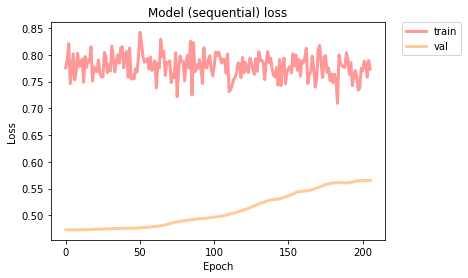

Epoch 1/1000
1/1 - 0s - loss: 0.7538 - mae: 0.5296 - val_loss: 0.2097 - val_mae: 0.1772
Epoch 2/1000
1/1 - 0s - loss: 0.7968 - mae: 0.5651 - val_loss: 0.2113 - val_mae: 0.1784
Epoch 3/1000
1/1 - 0s - loss: 0.8075 - mae: 0.5745 - val_loss: 0.2129 - val_mae: 0.1794
Epoch 4/1000
1/1 - 0s - loss: 0.8039 - mae: 0.5746 - val_loss: 0.2146 - val_mae: 0.1805
Epoch 5/1000
1/1 - 0s - loss: 0.8058 - mae: 0.5626 - val_loss: 0.2164 - val_mae: 0.1816
Epoch 6/1000
1/1 - 0s - loss: 0.7922 - mae: 0.5598 - val_loss: 0.2183 - val_mae: 0.1829
Epoch 7/1000
1/1 - 0s - loss: 0.7704 - mae: 0.5430 - val_loss: 0.2200 - val_mae: 0.1838
Epoch 8/1000
1/1 - 0s - loss: 0.7880 - mae: 0.5505 - val_loss: 0.2217 - val_mae: 0.1848
Epoch 9/1000
1/1 - 0s - loss: 0.7790 - mae: 0.5538 - val_loss: 0.2235 - val_mae: 0.1858
Epoch 10/1000
1/1 - 0s - loss: 0.7929 - mae: 0.5639 - val_loss: 0.2251 - val_mae: 0.1868
Epoch 11/1000
1/1 - 0s - loss: 0.8164 - mae: 0.5801 - val_loss: 0.2268 - val_mae: 0.1878
Epoch 12/1000
1/1 - 0s - loss:

Epoch 94/1000
1/1 - 0s - loss: 0.7890 - mae: 0.5602 - val_loss: 0.4562 - val_mae: 0.3069
Epoch 95/1000
1/1 - 0s - loss: 0.7731 - mae: 0.5466 - val_loss: 0.4592 - val_mae: 0.3085
Epoch 96/1000
1/1 - 0s - loss: 0.7734 - mae: 0.5516 - val_loss: 0.4610 - val_mae: 0.3094
Epoch 97/1000
1/1 - 0s - loss: 0.7528 - mae: 0.5259 - val_loss: 0.4632 - val_mae: 0.3105
Epoch 98/1000
1/1 - 0s - loss: 0.7753 - mae: 0.5458 - val_loss: 0.4655 - val_mae: 0.3117
Epoch 99/1000
1/1 - 0s - loss: 0.7775 - mae: 0.5460 - val_loss: 0.4673 - val_mae: 0.3126
Epoch 100/1000
1/1 - 0s - loss: 0.8087 - mae: 0.5778 - val_loss: 0.4697 - val_mae: 0.3139
Epoch 101/1000
1/1 - 0s - loss: 0.7895 - mae: 0.5695 - val_loss: 0.4714 - val_mae: 0.3146
Epoch 102/1000
1/1 - 0s - loss: 0.8047 - mae: 0.5766 - val_loss: 0.4727 - val_mae: 0.3153
Epoch 103/1000
1/1 - 0s - loss: 0.8038 - mae: 0.5755 - val_loss: 0.4747 - val_mae: 0.3164
Epoch 104/1000
1/1 - 0s - loss: 0.8002 - mae: 0.5707 - val_loss: 0.4765 - val_mae: 0.3172
Epoch 105/1000
1

1/1 - 0s - loss: 0.7704 - mae: 0.5341 - val_loss: 0.5886 - val_mae: 0.3937
Epoch 186/1000
1/1 - 0s - loss: 0.7849 - mae: 0.5596 - val_loss: 0.5890 - val_mae: 0.3941
Epoch 187/1000
1/1 - 0s - loss: 0.7661 - mae: 0.5400 - val_loss: 0.5897 - val_mae: 0.3948
Epoch 188/1000
1/1 - 0s - loss: 0.7808 - mae: 0.5519 - val_loss: 0.5904 - val_mae: 0.3956
Epoch 189/1000
1/1 - 0s - loss: 0.8182 - mae: 0.5887 - val_loss: 0.5911 - val_mae: 0.3961
Epoch 190/1000
1/1 - 0s - loss: 0.7376 - mae: 0.5156 - val_loss: 0.5913 - val_mae: 0.3962
Epoch 191/1000
1/1 - 0s - loss: 0.7641 - mae: 0.5399 - val_loss: 0.5913 - val_mae: 0.3963
Epoch 192/1000
1/1 - 0s - loss: 0.7562 - mae: 0.5167 - val_loss: 0.5913 - val_mae: 0.3962
Epoch 193/1000
1/1 - 0s - loss: 0.7775 - mae: 0.5438 - val_loss: 0.5916 - val_mae: 0.3964
Epoch 194/1000
1/1 - 0s - loss: 0.7777 - mae: 0.5470 - val_loss: 0.5919 - val_mae: 0.3966
Epoch 195/1000
1/1 - 0s - loss: 0.7723 - mae: 0.5379 - val_loss: 0.5924 - val_mae: 0.3969
Epoch 196/1000
1/1 - 0s -

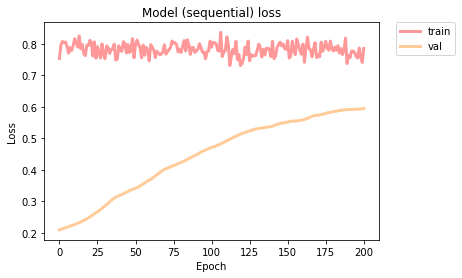

Epoch 1/1000
1/1 - 0s - loss: 0.7874 - mae: 0.5555 - val_loss: 0.2552 - val_mae: 0.2070
Epoch 2/1000
1/1 - 0s - loss: 0.7908 - mae: 0.5636 - val_loss: 0.2555 - val_mae: 0.2074
Epoch 3/1000
1/1 - 0s - loss: 0.7617 - mae: 0.5417 - val_loss: 0.2559 - val_mae: 0.2077
Epoch 4/1000
1/1 - 0s - loss: 0.7823 - mae: 0.5530 - val_loss: 0.2564 - val_mae: 0.2081
Epoch 5/1000
1/1 - 0s - loss: 0.7908 - mae: 0.5643 - val_loss: 0.2568 - val_mae: 0.2085
Epoch 6/1000
1/1 - 0s - loss: 0.7897 - mae: 0.5541 - val_loss: 0.2573 - val_mae: 0.2089
Epoch 7/1000
1/1 - 0s - loss: 0.7797 - mae: 0.5497 - val_loss: 0.2579 - val_mae: 0.2093
Epoch 8/1000
1/1 - 0s - loss: 0.7920 - mae: 0.5595 - val_loss: 0.2584 - val_mae: 0.2096
Epoch 9/1000
1/1 - 0s - loss: 0.7396 - mae: 0.5132 - val_loss: 0.2592 - val_mae: 0.2101
Epoch 10/1000
1/1 - 0s - loss: 0.7742 - mae: 0.5475 - val_loss: 0.2600 - val_mae: 0.2107
Epoch 11/1000
1/1 - 0s - loss: 0.7839 - mae: 0.5509 - val_loss: 0.2609 - val_mae: 0.2113
Epoch 12/1000
1/1 - 0s - loss:

1/1 - 0s - loss: 0.7675 - mae: 0.5506 - val_loss: 0.3756 - val_mae: 0.2671
Epoch 94/1000
1/1 - 0s - loss: 0.7788 - mae: 0.5456 - val_loss: 0.3774 - val_mae: 0.2679
Epoch 95/1000
1/1 - 0s - loss: 0.8141 - mae: 0.5878 - val_loss: 0.3793 - val_mae: 0.2687
Epoch 96/1000
1/1 - 0s - loss: 0.8175 - mae: 0.5892 - val_loss: 0.3814 - val_mae: 0.2695
Epoch 97/1000
1/1 - 0s - loss: 0.7982 - mae: 0.5668 - val_loss: 0.3834 - val_mae: 0.2703
Epoch 98/1000
1/1 - 0s - loss: 0.7846 - mae: 0.5558 - val_loss: 0.3852 - val_mae: 0.2710
Epoch 99/1000
1/1 - 0s - loss: 0.7787 - mae: 0.5586 - val_loss: 0.3862 - val_mae: 0.2714
Epoch 100/1000
1/1 - 0s - loss: 0.7613 - mae: 0.5356 - val_loss: 0.3868 - val_mae: 0.2715
Epoch 101/1000
1/1 - 0s - loss: 0.8134 - mae: 0.5918 - val_loss: 0.3873 - val_mae: 0.2716
Epoch 102/1000
1/1 - 0s - loss: 0.8013 - mae: 0.5784 - val_loss: 0.3881 - val_mae: 0.2719
Epoch 103/1000
1/1 - 0s - loss: 0.7774 - mae: 0.5528 - val_loss: 0.3888 - val_mae: 0.2721
Epoch 104/1000
1/1 - 0s - loss:

Epoch 185/1000
1/1 - 0s - loss: 0.7620 - mae: 0.5407 - val_loss: 0.4712 - val_mae: 0.3148
Epoch 186/1000
1/1 - 0s - loss: 0.7561 - mae: 0.5284 - val_loss: 0.4722 - val_mae: 0.3153
Epoch 187/1000
1/1 - 0s - loss: 0.8161 - mae: 0.5956 - val_loss: 0.4733 - val_mae: 0.3159
Epoch 188/1000
1/1 - 0s - loss: 0.7503 - mae: 0.5361 - val_loss: 0.4743 - val_mae: 0.3165
Epoch 189/1000
1/1 - 0s - loss: 0.7536 - mae: 0.5352 - val_loss: 0.4752 - val_mae: 0.3170
Epoch 190/1000
1/1 - 0s - loss: 0.8138 - mae: 0.5854 - val_loss: 0.4761 - val_mae: 0.3175
Epoch 191/1000
1/1 - 0s - loss: 0.7949 - mae: 0.5666 - val_loss: 0.4771 - val_mae: 0.3181
Epoch 192/1000
1/1 - 0s - loss: 0.7721 - mae: 0.5435 - val_loss: 0.4780 - val_mae: 0.3186
Epoch 193/1000
1/1 - 0s - loss: 0.7653 - mae: 0.5446 - val_loss: 0.4790 - val_mae: 0.3191
Epoch 194/1000
1/1 - 0s - loss: 0.7597 - mae: 0.5458 - val_loss: 0.4800 - val_mae: 0.3198
Epoch 195/1000
1/1 - 0s - loss: 0.7577 - mae: 0.5420 - val_loss: 0.4812 - val_mae: 0.3205
Epoch 196/

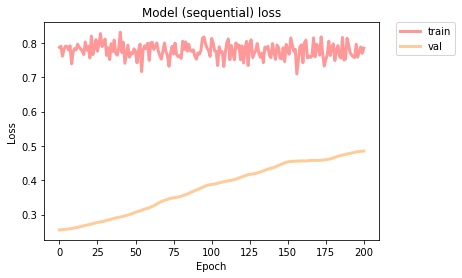

Epoch 1/1000
1/1 - 0s - loss: 0.8036 - mae: 0.5683 - val_loss: 0.2252 - val_mae: 0.1705
Epoch 2/1000
1/1 - 0s - loss: 0.7476 - mae: 0.5245 - val_loss: 0.2250 - val_mae: 0.1704
Epoch 3/1000
1/1 - 0s - loss: 0.7841 - mae: 0.5531 - val_loss: 0.2249 - val_mae: 0.1703
Epoch 4/1000
1/1 - 0s - loss: 0.7762 - mae: 0.5465 - val_loss: 0.2248 - val_mae: 0.1702
Epoch 5/1000
1/1 - 0s - loss: 0.7949 - mae: 0.5681 - val_loss: 0.2248 - val_mae: 0.1701
Epoch 6/1000
1/1 - 0s - loss: 0.7851 - mae: 0.5572 - val_loss: 0.2247 - val_mae: 0.1700
Epoch 7/1000
1/1 - 0s - loss: 0.7693 - mae: 0.5419 - val_loss: 0.2246 - val_mae: 0.1700
Epoch 8/1000
1/1 - 0s - loss: 0.8253 - mae: 0.5888 - val_loss: 0.2246 - val_mae: 0.1699
Epoch 9/1000
1/1 - 0s - loss: 0.7882 - mae: 0.5596 - val_loss: 0.2246 - val_mae: 0.1699
Epoch 10/1000
1/1 - 0s - loss: 0.7846 - mae: 0.5503 - val_loss: 0.2245 - val_mae: 0.1698
Epoch 11/1000
1/1 - 0s - loss: 0.7744 - mae: 0.5493 - val_loss: 0.2245 - val_mae: 0.1697
Epoch 12/1000
1/1 - 0s - loss:

1/1 - 0s - loss: 0.7681 - mae: 0.5422 - val_loss: 0.2228 - val_mae: 0.1675
Epoch 94/1000
1/1 - 0s - loss: 0.7995 - mae: 0.5718 - val_loss: 0.2229 - val_mae: 0.1676
Epoch 95/1000
1/1 - 0s - loss: 0.7916 - mae: 0.5693 - val_loss: 0.2230 - val_mae: 0.1676
Epoch 96/1000
1/1 - 0s - loss: 0.7679 - mae: 0.5437 - val_loss: 0.2231 - val_mae: 0.1677
Epoch 97/1000
1/1 - 0s - loss: 0.7638 - mae: 0.5400 - val_loss: 0.2233 - val_mae: 0.1677
Epoch 98/1000
1/1 - 0s - loss: 0.7860 - mae: 0.5586 - val_loss: 0.2235 - val_mae: 0.1678
Epoch 99/1000
1/1 - 0s - loss: 0.7776 - mae: 0.5511 - val_loss: 0.2236 - val_mae: 0.1679
Epoch 100/1000
1/1 - 0s - loss: 0.7720 - mae: 0.5467 - val_loss: 0.2235 - val_mae: 0.1678
Epoch 101/1000
1/1 - 0s - loss: 0.7835 - mae: 0.5574 - val_loss: 0.2236 - val_mae: 0.1679
Epoch 102/1000
1/1 - 0s - loss: 0.8119 - mae: 0.5906 - val_loss: 0.2237 - val_mae: 0.1679
Epoch 103/1000
1/1 - 0s - loss: 0.7667 - mae: 0.5522 - val_loss: 0.2237 - val_mae: 0.1679
Epoch 104/1000
1/1 - 0s - loss:

Epoch 185/1000
1/1 - 0s - loss: 0.7448 - mae: 0.5280 - val_loss: 0.2525 - val_mae: 0.1803
Epoch 186/1000
1/1 - 0s - loss: 0.7484 - mae: 0.5305 - val_loss: 0.2525 - val_mae: 0.1803
Epoch 187/1000
1/1 - 0s - loss: 0.7504 - mae: 0.5362 - val_loss: 0.2526 - val_mae: 0.1804
Epoch 188/1000
1/1 - 0s - loss: 0.7923 - mae: 0.5702 - val_loss: 0.2528 - val_mae: 0.1805
Epoch 189/1000
1/1 - 0s - loss: 0.7748 - mae: 0.5618 - val_loss: 0.2531 - val_mae: 0.1806
Epoch 190/1000
1/1 - 0s - loss: 0.7970 - mae: 0.5732 - val_loss: 0.2528 - val_mae: 0.1805
Epoch 191/1000
1/1 - 0s - loss: 0.7392 - mae: 0.5239 - val_loss: 0.2523 - val_mae: 0.1803
Epoch 192/1000
1/1 - 0s - loss: 0.7601 - mae: 0.5435 - val_loss: 0.2521 - val_mae: 0.1802
Epoch 193/1000
1/1 - 0s - loss: 0.7654 - mae: 0.5506 - val_loss: 0.2521 - val_mae: 0.1802
Epoch 194/1000
1/1 - 0s - loss: 0.7732 - mae: 0.5491 - val_loss: 0.2521 - val_mae: 0.1802
Epoch 195/1000
1/1 - 0s - loss: 0.7641 - mae: 0.5317 - val_loss: 0.2522 - val_mae: 0.1802
Epoch 196/

1/1 - 0s - loss: 0.7890 - mae: 0.5572 - val_loss: 0.2358 - val_mae: 0.1721
Epoch 277/1000
1/1 - 0s - loss: 0.7806 - mae: 0.5557 - val_loss: 0.2362 - val_mae: 0.1723
Epoch 278/1000
1/1 - 0s - loss: 0.7578 - mae: 0.5373 - val_loss: 0.2362 - val_mae: 0.1722
Epoch 279/1000
1/1 - 0s - loss: 0.7761 - mae: 0.5578 - val_loss: 0.2363 - val_mae: 0.1723
Epoch 280/1000
1/1 - 0s - loss: 0.7550 - mae: 0.5287 - val_loss: 0.2363 - val_mae: 0.1723
Epoch 281/1000
1/1 - 0s - loss: 0.7217 - mae: 0.5064 - val_loss: 0.2364 - val_mae: 0.1724
Epoch 282/1000
1/1 - 0s - loss: 0.7688 - mae: 0.5524 - val_loss: 0.2368 - val_mae: 0.1726
Epoch 283/1000
1/1 - 0s - loss: 0.7472 - mae: 0.5238 - val_loss: 0.2374 - val_mae: 0.1730
Epoch 284/1000
1/1 - 0s - loss: 0.7653 - mae: 0.5447 - val_loss: 0.2381 - val_mae: 0.1734
Epoch 285/1000
1/1 - 0s - loss: 0.7782 - mae: 0.5600 - val_loss: 0.2383 - val_mae: 0.1735
Epoch 286/1000
1/1 - 0s - loss: 0.7668 - mae: 0.5529 - val_loss: 0.2388 - val_mae: 0.1738
Epoch 287/1000
1/1 - 0s -

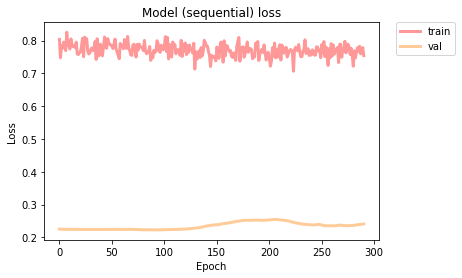

Epoch 1/1000
1/1 - 0s - loss: 0.7634 - mae: 0.5495 - val_loss: 0.2009 - val_mae: 0.1609
Epoch 2/1000
1/1 - 0s - loss: 0.7708 - mae: 0.5491 - val_loss: 0.2009 - val_mae: 0.1609
Epoch 3/1000
1/1 - 0s - loss: 0.7438 - mae: 0.5252 - val_loss: 0.2010 - val_mae: 0.1609
Epoch 4/1000
1/1 - 0s - loss: 0.7682 - mae: 0.5519 - val_loss: 0.2009 - val_mae: 0.1608
Epoch 5/1000
1/1 - 0s - loss: 0.7479 - mae: 0.5310 - val_loss: 0.2009 - val_mae: 0.1608
Epoch 6/1000
1/1 - 0s - loss: 0.7278 - mae: 0.5184 - val_loss: 0.2011 - val_mae: 0.1609
Epoch 7/1000
1/1 - 0s - loss: 0.7679 - mae: 0.5449 - val_loss: 0.2011 - val_mae: 0.1608
Epoch 8/1000
1/1 - 0s - loss: 0.7953 - mae: 0.5783 - val_loss: 0.2011 - val_mae: 0.1608
Epoch 9/1000
1/1 - 0s - loss: 0.7667 - mae: 0.5508 - val_loss: 0.2012 - val_mae: 0.1608
Epoch 10/1000
1/1 - 0s - loss: 0.7709 - mae: 0.5432 - val_loss: 0.2012 - val_mae: 0.1608
Epoch 11/1000
1/1 - 0s - loss: 0.7679 - mae: 0.5496 - val_loss: 0.2011 - val_mae: 0.1607
Epoch 12/1000
1/1 - 0s - loss:

Epoch 94/1000
1/1 - 0s - loss: 0.7496 - mae: 0.5238 - val_loss: 0.2025 - val_mae: 0.1591
Epoch 95/1000
1/1 - 0s - loss: 0.7652 - mae: 0.5428 - val_loss: 0.2024 - val_mae: 0.1590
Epoch 96/1000
1/1 - 0s - loss: 0.7615 - mae: 0.5451 - val_loss: 0.2023 - val_mae: 0.1589
Epoch 97/1000
1/1 - 0s - loss: 0.7327 - mae: 0.5184 - val_loss: 0.2023 - val_mae: 0.1588
Epoch 98/1000
1/1 - 0s - loss: 0.7675 - mae: 0.5457 - val_loss: 0.2021 - val_mae: 0.1587
Epoch 99/1000
1/1 - 0s - loss: 0.7615 - mae: 0.5458 - val_loss: 0.2022 - val_mae: 0.1587
Epoch 100/1000
1/1 - 0s - loss: 0.7374 - mae: 0.5259 - val_loss: 0.2021 - val_mae: 0.1586
Epoch 101/1000
1/1 - 0s - loss: 0.7739 - mae: 0.5523 - val_loss: 0.2019 - val_mae: 0.1584
Epoch 102/1000
1/1 - 0s - loss: 0.7538 - mae: 0.5330 - val_loss: 0.2018 - val_mae: 0.1583
Epoch 103/1000
1/1 - 0s - loss: 0.7743 - mae: 0.5494 - val_loss: 0.2017 - val_mae: 0.1581
Epoch 104/1000
1/1 - 0s - loss: 0.7781 - mae: 0.5560 - val_loss: 0.2016 - val_mae: 0.1580
Epoch 105/1000
1

1/1 - 0s - loss: 0.7195 - mae: 0.5033 - val_loss: 0.2057 - val_mae: 0.1629
Epoch 186/1000
1/1 - 0s - loss: 0.7635 - mae: 0.5445 - val_loss: 0.2059 - val_mae: 0.1631
Epoch 187/1000
1/1 - 0s - loss: 0.7796 - mae: 0.5555 - val_loss: 0.2060 - val_mae: 0.1633
Epoch 188/1000
1/1 - 0s - loss: 0.7265 - mae: 0.5218 - val_loss: 0.2060 - val_mae: 0.1633
Epoch 189/1000
1/1 - 0s - loss: 0.7536 - mae: 0.5351 - val_loss: 0.2064 - val_mae: 0.1636
Epoch 190/1000
1/1 - 0s - loss: 0.7359 - mae: 0.5158 - val_loss: 0.2064 - val_mae: 0.1636
Epoch 191/1000
1/1 - 0s - loss: 0.7339 - mae: 0.5255 - val_loss: 0.2065 - val_mae: 0.1636
Epoch 192/1000
1/1 - 0s - loss: 0.7687 - mae: 0.5501 - val_loss: 0.2067 - val_mae: 0.1638
Epoch 193/1000
1/1 - 0s - loss: 0.7154 - mae: 0.5060 - val_loss: 0.2071 - val_mae: 0.1641
Epoch 194/1000
1/1 - 0s - loss: 0.7663 - mae: 0.5483 - val_loss: 0.2074 - val_mae: 0.1643
Epoch 195/1000
1/1 - 0s - loss: 0.7622 - mae: 0.5471 - val_loss: 0.2077 - val_mae: 0.1646
Epoch 196/1000
1/1 - 0s -

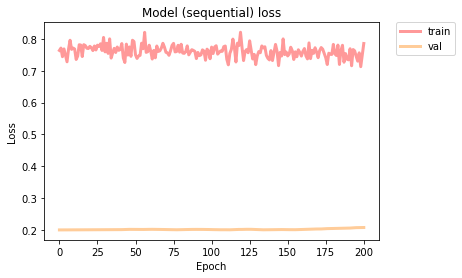

Epoch 1/1000
1/1 - 0s - loss: 0.7697 - mae: 0.5485 - val_loss: 0.4456 - val_mae: 0.3203
Epoch 2/1000
1/1 - 0s - loss: 0.7588 - mae: 0.5369 - val_loss: 0.4453 - val_mae: 0.3201
Epoch 3/1000
1/1 - 0s - loss: 0.7673 - mae: 0.5450 - val_loss: 0.4451 - val_mae: 0.3199
Epoch 4/1000
1/1 - 0s - loss: 0.7865 - mae: 0.5661 - val_loss: 0.4449 - val_mae: 0.3198
Epoch 5/1000
1/1 - 0s - loss: 0.7915 - mae: 0.5640 - val_loss: 0.4448 - val_mae: 0.3198
Epoch 6/1000
1/1 - 0s - loss: 0.7673 - mae: 0.5442 - val_loss: 0.4447 - val_mae: 0.3197
Epoch 7/1000
1/1 - 0s - loss: 0.7518 - mae: 0.5312 - val_loss: 0.4446 - val_mae: 0.3197
Epoch 8/1000
1/1 - 0s - loss: 0.7564 - mae: 0.5321 - val_loss: 0.4444 - val_mae: 0.3196
Epoch 9/1000
1/1 - 0s - loss: 0.7787 - mae: 0.5581 - val_loss: 0.4443 - val_mae: 0.3196
Epoch 10/1000
1/1 - 0s - loss: 0.7866 - mae: 0.5682 - val_loss: 0.4442 - val_mae: 0.3197
Epoch 11/1000
1/1 - 0s - loss: 0.7762 - mae: 0.5559 - val_loss: 0.4440 - val_mae: 0.3196
Epoch 12/1000
1/1 - 0s - loss:

1/1 - 0s - loss: 0.7578 - mae: 0.5520 - val_loss: 0.4349 - val_mae: 0.3187
Epoch 94/1000
1/1 - 0s - loss: 0.7647 - mae: 0.5442 - val_loss: 0.4349 - val_mae: 0.3187
Epoch 95/1000
1/1 - 0s - loss: 0.7697 - mae: 0.5495 - val_loss: 0.4349 - val_mae: 0.3186
Epoch 96/1000
1/1 - 0s - loss: 0.7348 - mae: 0.5256 - val_loss: 0.4348 - val_mae: 0.3185
Epoch 97/1000
1/1 - 0s - loss: 0.7552 - mae: 0.5372 - val_loss: 0.4348 - val_mae: 0.3183
Epoch 98/1000
1/1 - 0s - loss: 0.7509 - mae: 0.5390 - val_loss: 0.4347 - val_mae: 0.3182
Epoch 99/1000
1/1 - 0s - loss: 0.7928 - mae: 0.5669 - val_loss: 0.4346 - val_mae: 0.3181
Epoch 100/1000
1/1 - 0s - loss: 0.7746 - mae: 0.5571 - val_loss: 0.4346 - val_mae: 0.3181
Epoch 101/1000
1/1 - 0s - loss: 0.7711 - mae: 0.5551 - val_loss: 0.4345 - val_mae: 0.3180
Epoch 102/1000
1/1 - 0s - loss: 0.7583 - mae: 0.5405 - val_loss: 0.4345 - val_mae: 0.3181
Epoch 103/1000
1/1 - 0s - loss: 0.7632 - mae: 0.5445 - val_loss: 0.4346 - val_mae: 0.3183
Epoch 104/1000
1/1 - 0s - loss:

Epoch 185/1000
1/1 - 0s - loss: 0.7435 - mae: 0.5264 - val_loss: 0.4340 - val_mae: 0.3214
Epoch 186/1000
1/1 - 0s - loss: 0.7718 - mae: 0.5492 - val_loss: 0.4340 - val_mae: 0.3215
Epoch 187/1000
1/1 - 0s - loss: 0.7585 - mae: 0.5426 - val_loss: 0.4340 - val_mae: 0.3215
Epoch 188/1000
1/1 - 0s - loss: 0.7455 - mae: 0.5378 - val_loss: 0.4339 - val_mae: 0.3213
Epoch 189/1000
1/1 - 0s - loss: 0.7830 - mae: 0.5720 - val_loss: 0.4339 - val_mae: 0.3213
Epoch 190/1000
1/1 - 0s - loss: 0.7419 - mae: 0.5278 - val_loss: 0.4339 - val_mae: 0.3214
Epoch 191/1000
1/1 - 0s - loss: 0.7260 - mae: 0.5146 - val_loss: 0.4338 - val_mae: 0.3213
Epoch 192/1000
1/1 - 0s - loss: 0.7464 - mae: 0.5277 - val_loss: 0.4338 - val_mae: 0.3213
Epoch 193/1000
1/1 - 0s - loss: 0.7815 - mae: 0.5694 - val_loss: 0.4338 - val_mae: 0.3214
Epoch 194/1000
1/1 - 0s - loss: 0.7789 - mae: 0.5575 - val_loss: 0.4336 - val_mae: 0.3212
Epoch 195/1000
1/1 - 0s - loss: 0.7448 - mae: 0.5261 - val_loss: 0.4336 - val_mae: 0.3211
Epoch 196/

Epoch 277/1000
1/1 - 0s - loss: 0.7464 - mae: 0.5295 - val_loss: 0.4322 - val_mae: 0.3225
Epoch 278/1000
1/1 - 0s - loss: 0.7566 - mae: 0.5295 - val_loss: 0.4323 - val_mae: 0.3227
Epoch 279/1000
1/1 - 0s - loss: 0.7474 - mae: 0.5346 - val_loss: 0.4325 - val_mae: 0.3231
Epoch 280/1000
1/1 - 0s - loss: 0.7794 - mae: 0.5600 - val_loss: 0.4326 - val_mae: 0.3233
Epoch 281/1000
1/1 - 0s - loss: 0.7359 - mae: 0.5231 - val_loss: 0.4326 - val_mae: 0.3234
Epoch 282/1000
1/1 - 0s - loss: 0.7747 - mae: 0.5536 - val_loss: 0.4327 - val_mae: 0.3236
Epoch 283/1000
1/1 - 0s - loss: 0.7218 - mae: 0.5134 - val_loss: 0.4328 - val_mae: 0.3238
Epoch 284/1000
1/1 - 0s - loss: 0.7581 - mae: 0.5440 - val_loss: 0.4328 - val_mae: 0.3238
Epoch 285/1000
1/1 - 0s - loss: 0.7336 - mae: 0.5236 - val_loss: 0.4328 - val_mae: 0.3238
Epoch 286/1000
1/1 - 0s - loss: 0.7709 - mae: 0.5571 - val_loss: 0.4327 - val_mae: 0.3237
Epoch 287/1000
1/1 - 0s - loss: 0.7416 - mae: 0.5224 - val_loss: 0.4327 - val_mae: 0.3236
Epoch 288/

Epoch 369/1000
1/1 - 0s - loss: 0.7398 - mae: 0.5338 - val_loss: 0.4296 - val_mae: 0.3183
Epoch 370/1000
1/1 - 0s - loss: 0.7274 - mae: 0.5174 - val_loss: 0.4296 - val_mae: 0.3184
Epoch 371/1000
1/1 - 0s - loss: 0.7267 - mae: 0.5169 - val_loss: 0.4296 - val_mae: 0.3184
Epoch 372/1000
1/1 - 0s - loss: 0.7130 - mae: 0.5031 - val_loss: 0.4297 - val_mae: 0.3184
Epoch 373/1000
1/1 - 0s - loss: 0.7548 - mae: 0.5407 - val_loss: 0.4298 - val_mae: 0.3185
Epoch 374/1000
1/1 - 0s - loss: 0.7275 - mae: 0.5121 - val_loss: 0.4299 - val_mae: 0.3187
Epoch 375/1000
1/1 - 0s - loss: 0.7230 - mae: 0.5057 - val_loss: 0.4300 - val_mae: 0.3189
Epoch 376/1000
1/1 - 0s - loss: 0.7892 - mae: 0.5656 - val_loss: 0.4300 - val_mae: 0.3188
Epoch 377/1000
1/1 - 0s - loss: 0.7433 - mae: 0.5246 - val_loss: 0.4301 - val_mae: 0.3187
Epoch 378/1000
1/1 - 0s - loss: 0.7262 - mae: 0.5108 - val_loss: 0.4301 - val_mae: 0.3188
Epoch 379/1000
1/1 - 0s - loss: 0.7292 - mae: 0.5192 - val_loss: 0.4302 - val_mae: 0.3188
Epoch 380/

1/1 - 0s - loss: 0.7324 - mae: 0.5272 - val_loss: 0.4313 - val_mae: 0.3209
Epoch 461/1000
1/1 - 0s - loss: 0.7420 - mae: 0.5233 - val_loss: 0.4312 - val_mae: 0.3207
Epoch 462/1000
1/1 - 0s - loss: 0.7686 - mae: 0.5521 - val_loss: 0.4311 - val_mae: 0.3205
Epoch 463/1000
1/1 - 0s - loss: 0.7571 - mae: 0.5434 - val_loss: 0.4311 - val_mae: 0.3204
Epoch 464/1000
1/1 - 0s - loss: 0.7186 - mae: 0.5069 - val_loss: 0.4310 - val_mae: 0.3203
Epoch 465/1000
1/1 - 0s - loss: 0.7507 - mae: 0.5331 - val_loss: 0.4309 - val_mae: 0.3202
Epoch 466/1000
1/1 - 0s - loss: 0.7464 - mae: 0.5387 - val_loss: 0.4307 - val_mae: 0.3199
Epoch 467/1000
1/1 - 0s - loss: 0.7517 - mae: 0.5343 - val_loss: 0.4305 - val_mae: 0.3197
Epoch 468/1000
1/1 - 0s - loss: 0.7502 - mae: 0.5369 - val_loss: 0.4303 - val_mae: 0.3194
Epoch 469/1000
1/1 - 0s - loss: 0.7431 - mae: 0.5333 - val_loss: 0.4303 - val_mae: 0.3194
Epoch 470/1000
1/1 - 0s - loss: 0.7329 - mae: 0.5211 - val_loss: 0.4302 - val_mae: 0.3194
Epoch 471/1000
1/1 - 0s -

Epoch 552/1000
1/1 - 0s - loss: 0.7200 - mae: 0.5040 - val_loss: 0.4315 - val_mae: 0.3196
Epoch 553/1000
1/1 - 0s - loss: 0.7396 - mae: 0.5285 - val_loss: 0.4317 - val_mae: 0.3198
Epoch 554/1000
1/1 - 0s - loss: 0.6976 - mae: 0.4967 - val_loss: 0.4319 - val_mae: 0.3201
Epoch 555/1000
1/1 - 0s - loss: 0.7292 - mae: 0.5135 - val_loss: 0.4322 - val_mae: 0.3205
Epoch 556/1000
1/1 - 0s - loss: 0.7318 - mae: 0.5167 - val_loss: 0.4324 - val_mae: 0.3207
Epoch 557/1000
1/1 - 0s - loss: 0.7254 - mae: 0.5127 - val_loss: 0.4325 - val_mae: 0.3207
Epoch 558/1000
1/1 - 0s - loss: 0.7268 - mae: 0.5093 - val_loss: 0.4326 - val_mae: 0.3207
Epoch 559/1000
1/1 - 0s - loss: 0.7349 - mae: 0.5192 - val_loss: 0.4326 - val_mae: 0.3208
Epoch 560/1000
1/1 - 0s - loss: 0.7253 - mae: 0.5145 - val_loss: 0.4327 - val_mae: 0.3208
Epoch 561/1000
1/1 - 0s - loss: 0.7278 - mae: 0.5174 - val_loss: 0.4326 - val_mae: 0.3206
Epoch 562/1000
1/1 - 0s - loss: 0.7150 - mae: 0.5084 - val_loss: 0.4326 - val_mae: 0.3206
Epoch 563/

Epoch 644/1000
1/1 - 0s - loss: 0.7163 - mae: 0.5089 - val_loss: 0.4267 - val_mae: 0.3125
Epoch 645/1000
1/1 - 0s - loss: 0.7146 - mae: 0.5086 - val_loss: 0.4266 - val_mae: 0.3124
Epoch 646/1000
1/1 - 0s - loss: 0.7168 - mae: 0.5065 - val_loss: 0.4266 - val_mae: 0.3124
Epoch 647/1000
1/1 - 0s - loss: 0.7344 - mae: 0.5171 - val_loss: 0.4265 - val_mae: 0.3123
Epoch 648/1000
1/1 - 0s - loss: 0.6908 - mae: 0.4833 - val_loss: 0.4265 - val_mae: 0.3121
Epoch 649/1000
1/1 - 0s - loss: 0.7331 - mae: 0.5276 - val_loss: 0.4264 - val_mae: 0.3119
Epoch 650/1000
1/1 - 0s - loss: 0.7446 - mae: 0.5300 - val_loss: 0.4264 - val_mae: 0.3118
Epoch 651/1000
1/1 - 0s - loss: 0.6984 - mae: 0.4900 - val_loss: 0.4264 - val_mae: 0.3118
Epoch 652/1000
1/1 - 0s - loss: 0.6723 - mae: 0.4731 - val_loss: 0.4264 - val_mae: 0.3117
Epoch 653/1000
1/1 - 0s - loss: 0.7343 - mae: 0.5174 - val_loss: 0.4263 - val_mae: 0.3116
Epoch 654/1000
1/1 - 0s - loss: 0.7394 - mae: 0.5286 - val_loss: 0.4263 - val_mae: 0.3115
Epoch 655/

Epoch 736/1000
1/1 - 0s - loss: 0.7259 - mae: 0.5201 - val_loss: 0.4290 - val_mae: 0.3155
Epoch 737/1000
1/1 - 0s - loss: 0.7448 - mae: 0.5301 - val_loss: 0.4291 - val_mae: 0.3156
Epoch 738/1000
1/1 - 0s - loss: 0.7320 - mae: 0.5223 - val_loss: 0.4291 - val_mae: 0.3157
Epoch 739/1000
1/1 - 0s - loss: 0.7240 - mae: 0.5121 - val_loss: 0.4291 - val_mae: 0.3155
Epoch 740/1000
1/1 - 0s - loss: 0.7144 - mae: 0.5044 - val_loss: 0.4293 - val_mae: 0.3158
Epoch 741/1000
1/1 - 0s - loss: 0.7349 - mae: 0.5123 - val_loss: 0.4293 - val_mae: 0.3158
Epoch 742/1000
1/1 - 0s - loss: 0.7022 - mae: 0.4967 - val_loss: 0.4294 - val_mae: 0.3160
Epoch 743/1000
1/1 - 0s - loss: 0.6787 - mae: 0.4801 - val_loss: 0.4295 - val_mae: 0.3162
Epoch 744/1000
1/1 - 0s - loss: 0.7045 - mae: 0.4982 - val_loss: 0.4296 - val_mae: 0.3163
Epoch 745/1000
1/1 - 0s - loss: 0.6990 - mae: 0.4928 - val_loss: 0.4297 - val_mae: 0.3164
Epoch 746/1000
1/1 - 0s - loss: 0.7001 - mae: 0.4919 - val_loss: 0.4296 - val_mae: 0.3163
Epoch 747/

1/1 - 0s - loss: 0.7335 - mae: 0.5263 - val_loss: 0.4273 - val_mae: 0.3116
Epoch 828/1000
1/1 - 0s - loss: 0.7056 - mae: 0.4870 - val_loss: 0.4274 - val_mae: 0.3117
Epoch 829/1000
1/1 - 0s - loss: 0.7408 - mae: 0.5218 - val_loss: 0.4275 - val_mae: 0.3118
Epoch 830/1000
1/1 - 0s - loss: 0.7102 - mae: 0.5023 - val_loss: 0.4276 - val_mae: 0.3120
Epoch 831/1000
1/1 - 0s - loss: 0.7494 - mae: 0.5402 - val_loss: 0.4276 - val_mae: 0.3120
Epoch 832/1000
1/1 - 0s - loss: 0.6942 - mae: 0.4885 - val_loss: 0.4277 - val_mae: 0.3122
Epoch 833/1000
1/1 - 0s - loss: 0.7316 - mae: 0.5238 - val_loss: 0.4278 - val_mae: 0.3122
Epoch 834/1000
1/1 - 0s - loss: 0.7000 - mae: 0.4898 - val_loss: 0.4279 - val_mae: 0.3123
Epoch 835/1000
1/1 - 0s - loss: 0.7385 - mae: 0.5205 - val_loss: 0.4279 - val_mae: 0.3123
Epoch 836/1000
1/1 - 0s - loss: 0.7217 - mae: 0.5135 - val_loss: 0.4279 - val_mae: 0.3123
Epoch 837/1000
1/1 - 0s - loss: 0.7238 - mae: 0.5099 - val_loss: 0.4280 - val_mae: 0.3124
Epoch 838/1000
1/1 - 0s -

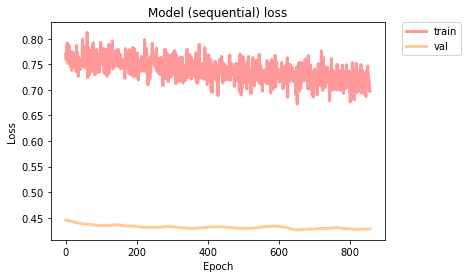

Epoch 1/1000
1/1 - 0s - loss: 0.7012 - mae: 0.4904 - val_loss: 0.4764 - val_mae: 0.3656
Epoch 2/1000
1/1 - 0s - loss: 0.7307 - mae: 0.5178 - val_loss: 0.4763 - val_mae: 0.3656
Epoch 3/1000
1/1 - 0s - loss: 0.7257 - mae: 0.5157 - val_loss: 0.4762 - val_mae: 0.3657
Epoch 4/1000
1/1 - 0s - loss: 0.7469 - mae: 0.5316 - val_loss: 0.4759 - val_mae: 0.3655
Epoch 5/1000
1/1 - 0s - loss: 0.7496 - mae: 0.5268 - val_loss: 0.4753 - val_mae: 0.3651
Epoch 6/1000
1/1 - 0s - loss: 0.7508 - mae: 0.5317 - val_loss: 0.4750 - val_mae: 0.3649
Epoch 7/1000
1/1 - 0s - loss: 0.7336 - mae: 0.5206 - val_loss: 0.4749 - val_mae: 0.3649
Epoch 8/1000
1/1 - 0s - loss: 0.7266 - mae: 0.5133 - val_loss: 0.4749 - val_mae: 0.3650
Epoch 9/1000
1/1 - 0s - loss: 0.7219 - mae: 0.5040 - val_loss: 0.4748 - val_mae: 0.3650
Epoch 10/1000
1/1 - 0s - loss: 0.7232 - mae: 0.5212 - val_loss: 0.4748 - val_mae: 0.3650
Epoch 11/1000
1/1 - 0s - loss: 0.7501 - mae: 0.5282 - val_loss: 0.4745 - val_mae: 0.3649
Epoch 12/1000
1/1 - 0s - loss:

1/1 - 0s - loss: 0.7010 - mae: 0.4930 - val_loss: 0.4707 - val_mae: 0.3643
Epoch 94/1000
1/1 - 0s - loss: 0.7094 - mae: 0.4929 - val_loss: 0.4704 - val_mae: 0.3641
Epoch 95/1000
1/1 - 0s - loss: 0.7206 - mae: 0.5062 - val_loss: 0.4700 - val_mae: 0.3639
Epoch 96/1000
1/1 - 0s - loss: 0.7231 - mae: 0.5058 - val_loss: 0.4697 - val_mae: 0.3637
Epoch 97/1000
1/1 - 0s - loss: 0.7235 - mae: 0.5097 - val_loss: 0.4693 - val_mae: 0.3635
Epoch 98/1000
1/1 - 0s - loss: 0.7165 - mae: 0.5014 - val_loss: 0.4689 - val_mae: 0.3633
Epoch 99/1000
1/1 - 0s - loss: 0.7349 - mae: 0.5149 - val_loss: 0.4684 - val_mae: 0.3628
Epoch 100/1000
1/1 - 0s - loss: 0.7225 - mae: 0.5098 - val_loss: 0.4680 - val_mae: 0.3626
Epoch 101/1000
1/1 - 0s - loss: 0.7219 - mae: 0.5126 - val_loss: 0.4677 - val_mae: 0.3625
Epoch 102/1000
1/1 - 0s - loss: 0.7231 - mae: 0.5068 - val_loss: 0.4674 - val_mae: 0.3623
Epoch 103/1000
1/1 - 0s - loss: 0.7642 - mae: 0.5404 - val_loss: 0.4670 - val_mae: 0.3620
Epoch 104/1000
1/1 - 0s - loss:

Epoch 185/1000
1/1 - 0s - loss: 0.7189 - mae: 0.5080 - val_loss: 0.4688 - val_mae: 0.3645
Epoch 186/1000
1/1 - 0s - loss: 0.7154 - mae: 0.5046 - val_loss: 0.4689 - val_mae: 0.3646
Epoch 187/1000
1/1 - 0s - loss: 0.7142 - mae: 0.5038 - val_loss: 0.4690 - val_mae: 0.3647
Epoch 188/1000
1/1 - 0s - loss: 0.7264 - mae: 0.5056 - val_loss: 0.4690 - val_mae: 0.3646
Epoch 189/1000
1/1 - 0s - loss: 0.7255 - mae: 0.5057 - val_loss: 0.4690 - val_mae: 0.3646
Epoch 190/1000
1/1 - 0s - loss: 0.7446 - mae: 0.5282 - val_loss: 0.4689 - val_mae: 0.3645
Epoch 191/1000
1/1 - 0s - loss: 0.7194 - mae: 0.5046 - val_loss: 0.4687 - val_mae: 0.3643
Epoch 192/1000
1/1 - 0s - loss: 0.7195 - mae: 0.5149 - val_loss: 0.4686 - val_mae: 0.3642
Epoch 193/1000
1/1 - 0s - loss: 0.7190 - mae: 0.5096 - val_loss: 0.4684 - val_mae: 0.3641
Epoch 194/1000
1/1 - 0s - loss: 0.7161 - mae: 0.5032 - val_loss: 0.4682 - val_mae: 0.3638
Epoch 195/1000
1/1 - 0s - loss: 0.7231 - mae: 0.5076 - val_loss: 0.4680 - val_mae: 0.3636
Epoch 196/

Epoch 277/1000
1/1 - 0s - loss: 0.7372 - mae: 0.5176 - val_loss: 0.4606 - val_mae: 0.3555
Epoch 278/1000
1/1 - 0s - loss: 0.7109 - mae: 0.4981 - val_loss: 0.4605 - val_mae: 0.3555
Epoch 279/1000
1/1 - 0s - loss: 0.7439 - mae: 0.5257 - val_loss: 0.4603 - val_mae: 0.3555
Epoch 280/1000
1/1 - 0s - loss: 0.7172 - mae: 0.4995 - val_loss: 0.4602 - val_mae: 0.3554
Epoch 281/1000
1/1 - 0s - loss: 0.7036 - mae: 0.4881 - val_loss: 0.4601 - val_mae: 0.3554
Epoch 282/1000
1/1 - 0s - loss: 0.6882 - mae: 0.4786 - val_loss: 0.4601 - val_mae: 0.3555
Epoch 283/1000
1/1 - 0s - loss: 0.7138 - mae: 0.5050 - val_loss: 0.4600 - val_mae: 0.3554
Epoch 284/1000
1/1 - 0s - loss: 0.7203 - mae: 0.5073 - val_loss: 0.4598 - val_mae: 0.3553
Epoch 285/1000
1/1 - 0s - loss: 0.7122 - mae: 0.4975 - val_loss: 0.4596 - val_mae: 0.3550
Epoch 286/1000
1/1 - 0s - loss: 0.6894 - mae: 0.4861 - val_loss: 0.4595 - val_mae: 0.3549
Epoch 287/1000
1/1 - 0s - loss: 0.7161 - mae: 0.5124 - val_loss: 0.4593 - val_mae: 0.3549
Epoch 288/

Epoch 369/1000
1/1 - 0s - loss: 0.6987 - mae: 0.4901 - val_loss: 0.4492 - val_mae: 0.3456
Epoch 370/1000
1/1 - 0s - loss: 0.7003 - mae: 0.4959 - val_loss: 0.4491 - val_mae: 0.3456
Epoch 371/1000
1/1 - 0s - loss: 0.6901 - mae: 0.4755 - val_loss: 0.4492 - val_mae: 0.3457
Epoch 372/1000
1/1 - 0s - loss: 0.7025 - mae: 0.4931 - val_loss: 0.4491 - val_mae: 0.3456
Epoch 373/1000
1/1 - 0s - loss: 0.6957 - mae: 0.4897 - val_loss: 0.4491 - val_mae: 0.3457
Epoch 374/1000
1/1 - 0s - loss: 0.7178 - mae: 0.5117 - val_loss: 0.4491 - val_mae: 0.3456
Epoch 375/1000
1/1 - 0s - loss: 0.6891 - mae: 0.4799 - val_loss: 0.4492 - val_mae: 0.3457
Epoch 376/1000
1/1 - 0s - loss: 0.7013 - mae: 0.4890 - val_loss: 0.4492 - val_mae: 0.3457
Epoch 377/1000
1/1 - 0s - loss: 0.7348 - mae: 0.5217 - val_loss: 0.4493 - val_mae: 0.3458
Epoch 378/1000
1/1 - 0s - loss: 0.7267 - mae: 0.5109 - val_loss: 0.4494 - val_mae: 0.3459
Epoch 379/1000
1/1 - 0s - loss: 0.7128 - mae: 0.5089 - val_loss: 0.4497 - val_mae: 0.3462
Epoch 380/

Epoch 461/1000
1/1 - 0s - loss: 0.6891 - mae: 0.4891 - val_loss: 0.4420 - val_mae: 0.3340
Epoch 462/1000
1/1 - 0s - loss: 0.7262 - mae: 0.5116 - val_loss: 0.4419 - val_mae: 0.3339
Epoch 463/1000
1/1 - 0s - loss: 0.6979 - mae: 0.4847 - val_loss: 0.4418 - val_mae: 0.3337
Epoch 464/1000
1/1 - 0s - loss: 0.7183 - mae: 0.5038 - val_loss: 0.4419 - val_mae: 0.3338
Epoch 465/1000
1/1 - 0s - loss: 0.6948 - mae: 0.4869 - val_loss: 0.4419 - val_mae: 0.3339
Epoch 466/1000
1/1 - 0s - loss: 0.6741 - mae: 0.4747 - val_loss: 0.4419 - val_mae: 0.3338
Epoch 467/1000
1/1 - 0s - loss: 0.7216 - mae: 0.5055 - val_loss: 0.4419 - val_mae: 0.3339
Epoch 468/1000
1/1 - 0s - loss: 0.6912 - mae: 0.4852 - val_loss: 0.4418 - val_mae: 0.3339
Epoch 469/1000
1/1 - 0s - loss: 0.7132 - mae: 0.4954 - val_loss: 0.4418 - val_mae: 0.3338
Epoch 470/1000
1/1 - 0s - loss: 0.7088 - mae: 0.4952 - val_loss: 0.4418 - val_mae: 0.3339
Epoch 471/1000
1/1 - 0s - loss: 0.7194 - mae: 0.5039 - val_loss: 0.4417 - val_mae: 0.3339
Epoch 472/

1/1 - 0s - loss: 0.6875 - mae: 0.4788 - val_loss: 0.4410 - val_mae: 0.3339
Epoch 553/1000
1/1 - 0s - loss: 0.6847 - mae: 0.4802 - val_loss: 0.4411 - val_mae: 0.3341
Epoch 554/1000
1/1 - 0s - loss: 0.6938 - mae: 0.4789 - val_loss: 0.4411 - val_mae: 0.3341
Epoch 555/1000
1/1 - 0s - loss: 0.6824 - mae: 0.4832 - val_loss: 0.4412 - val_mae: 0.3342
Epoch 556/1000
1/1 - 0s - loss: 0.7040 - mae: 0.4926 - val_loss: 0.4413 - val_mae: 0.3343
Epoch 557/1000
1/1 - 0s - loss: 0.6837 - mae: 0.4788 - val_loss: 0.4413 - val_mae: 0.3344
Epoch 558/1000
1/1 - 0s - loss: 0.6972 - mae: 0.4896 - val_loss: 0.4413 - val_mae: 0.3343
Epoch 559/1000
1/1 - 0s - loss: 0.7114 - mae: 0.4990 - val_loss: 0.4413 - val_mae: 0.3343
Epoch 560/1000
1/1 - 0s - loss: 0.7107 - mae: 0.5045 - val_loss: 0.4413 - val_mae: 0.3342
Epoch 561/1000
1/1 - 0s - loss: 0.6928 - mae: 0.4873 - val_loss: 0.4413 - val_mae: 0.3340
Epoch 562/1000
1/1 - 0s - loss: 0.6729 - mae: 0.4770 - val_loss: 0.4412 - val_mae: 0.3339
Epoch 563/1000
1/1 - 0s -

Epoch 644/1000
1/1 - 0s - loss: 0.6770 - mae: 0.4769 - val_loss: 0.4384 - val_mae: 0.3309
Epoch 645/1000
1/1 - 0s - loss: 0.6754 - mae: 0.4658 - val_loss: 0.4383 - val_mae: 0.3307
Epoch 646/1000
1/1 - 0s - loss: 0.7117 - mae: 0.4921 - val_loss: 0.4383 - val_mae: 0.3308
Epoch 647/1000
1/1 - 0s - loss: 0.6705 - mae: 0.4717 - val_loss: 0.4382 - val_mae: 0.3307
Epoch 648/1000
1/1 - 0s - loss: 0.6872 - mae: 0.4773 - val_loss: 0.4382 - val_mae: 0.3306
Epoch 649/1000
1/1 - 0s - loss: 0.6728 - mae: 0.4706 - val_loss: 0.4382 - val_mae: 0.3307
Epoch 650/1000
1/1 - 0s - loss: 0.7051 - mae: 0.4961 - val_loss: 0.4382 - val_mae: 0.3308
Epoch 651/1000
1/1 - 0s - loss: 0.6996 - mae: 0.4894 - val_loss: 0.4382 - val_mae: 0.3308
Epoch 652/1000
1/1 - 0s - loss: 0.6963 - mae: 0.4863 - val_loss: 0.4382 - val_mae: 0.3309
Epoch 653/1000
1/1 - 0s - loss: 0.6807 - mae: 0.4760 - val_loss: 0.4382 - val_mae: 0.3310
Epoch 654/1000
1/1 - 0s - loss: 0.6950 - mae: 0.4893 - val_loss: 0.4382 - val_mae: 0.3311
Epoch 655/

1/1 - 0s - loss: 0.7137 - mae: 0.5036 - val_loss: 0.4424 - val_mae: 0.3355
Epoch 736/1000
1/1 - 0s - loss: 0.6822 - mae: 0.4845 - val_loss: 0.4425 - val_mae: 0.3356
Epoch 737/1000
1/1 - 0s - loss: 0.6768 - mae: 0.4748 - val_loss: 0.4425 - val_mae: 0.3356
Epoch 738/1000
1/1 - 0s - loss: 0.6982 - mae: 0.4898 - val_loss: 0.4425 - val_mae: 0.3355
Epoch 739/1000
1/1 - 0s - loss: 0.7055 - mae: 0.4929 - val_loss: 0.4424 - val_mae: 0.3354
Epoch 740/1000
1/1 - 0s - loss: 0.6880 - mae: 0.4819 - val_loss: 0.4423 - val_mae: 0.3354
Epoch 741/1000
1/1 - 0s - loss: 0.6908 - mae: 0.4900 - val_loss: 0.4423 - val_mae: 0.3354
Epoch 742/1000
1/1 - 0s - loss: 0.6818 - mae: 0.4804 - val_loss: 0.4423 - val_mae: 0.3353
Epoch 743/1000
1/1 - 0s - loss: 0.6746 - mae: 0.4730 - val_loss: 0.4423 - val_mae: 0.3352
Epoch 744/1000
1/1 - 0s - loss: 0.6933 - mae: 0.4867 - val_loss: 0.4423 - val_mae: 0.3352
Epoch 745/1000
1/1 - 0s - loss: 0.6881 - mae: 0.4807 - val_loss: 0.4424 - val_mae: 0.3352
Epoch 746/1000
1/1 - 0s -

Epoch 827/1000
1/1 - 0s - loss: 0.7288 - mae: 0.5179 - val_loss: 0.4371 - val_mae: 0.3276
Epoch 828/1000
1/1 - 0s - loss: 0.7001 - mae: 0.4890 - val_loss: 0.4371 - val_mae: 0.3276
Epoch 829/1000
1/1 - 0s - loss: 0.6919 - mae: 0.4806 - val_loss: 0.4371 - val_mae: 0.3276
Epoch 830/1000
1/1 - 0s - loss: 0.6592 - mae: 0.4564 - val_loss: 0.4372 - val_mae: 0.3277
Epoch 831/1000
1/1 - 0s - loss: 0.7066 - mae: 0.5049 - val_loss: 0.4373 - val_mae: 0.3280
Epoch 832/1000
1/1 - 0s - loss: 0.7026 - mae: 0.4876 - val_loss: 0.4373 - val_mae: 0.3280
Epoch 833/1000
1/1 - 0s - loss: 0.6845 - mae: 0.4720 - val_loss: 0.4373 - val_mae: 0.3280
Epoch 834/1000
1/1 - 0s - loss: 0.6995 - mae: 0.4899 - val_loss: 0.4372 - val_mae: 0.3278
Epoch 835/1000
1/1 - 0s - loss: 0.6954 - mae: 0.4823 - val_loss: 0.4372 - val_mae: 0.3279
Epoch 836/1000
1/1 - 0s - loss: 0.6803 - mae: 0.4671 - val_loss: 0.4371 - val_mae: 0.3278
Epoch 837/1000
1/1 - 0s - loss: 0.6983 - mae: 0.4843 - val_loss: 0.4370 - val_mae: 0.3277
Epoch 838/

Epoch 919/1000
1/1 - 0s - loss: 0.6751 - mae: 0.4722 - val_loss: 0.4305 - val_mae: 0.3185
Epoch 920/1000
1/1 - 0s - loss: 0.6697 - mae: 0.4574 - val_loss: 0.4305 - val_mae: 0.3183
Epoch 921/1000
1/1 - 0s - loss: 0.6891 - mae: 0.4857 - val_loss: 0.4305 - val_mae: 0.3182
Epoch 922/1000
1/1 - 0s - loss: 0.6775 - mae: 0.4718 - val_loss: 0.4305 - val_mae: 0.3182
Epoch 923/1000
1/1 - 0s - loss: 0.6987 - mae: 0.4851 - val_loss: 0.4304 - val_mae: 0.3180
Epoch 924/1000
1/1 - 0s - loss: 0.6882 - mae: 0.4798 - val_loss: 0.4304 - val_mae: 0.3179
Epoch 925/1000
1/1 - 0s - loss: 0.6883 - mae: 0.4819 - val_loss: 0.4303 - val_mae: 0.3179
Epoch 926/1000
1/1 - 0s - loss: 0.6749 - mae: 0.4737 - val_loss: 0.4304 - val_mae: 0.3180
Epoch 927/1000
1/1 - 0s - loss: 0.6949 - mae: 0.4863 - val_loss: 0.4304 - val_mae: 0.3180
Epoch 928/1000
1/1 - 0s - loss: 0.6851 - mae: 0.4710 - val_loss: 0.4304 - val_mae: 0.3181
Epoch 929/1000
1/1 - 0s - loss: 0.6842 - mae: 0.4747 - val_loss: 0.4305 - val_mae: 0.3181
Epoch 930/

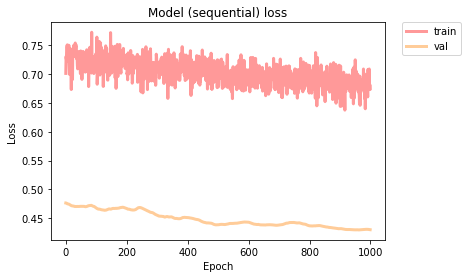

Epoch 1/1000
2/2 - 0s - loss: 0.6869 - mae: 0.4736 - val_loss: 0.4170 - val_mae: 0.2912
Epoch 2/1000
2/2 - 0s - loss: 0.6928 - mae: 0.4823 - val_loss: 0.4166 - val_mae: 0.2916
Epoch 3/1000
2/2 - 0s - loss: 0.6738 - mae: 0.4589 - val_loss: 0.4157 - val_mae: 0.2912
Epoch 4/1000
2/2 - 0s - loss: 0.6825 - mae: 0.4812 - val_loss: 0.4148 - val_mae: 0.2907
Epoch 5/1000
2/2 - 0s - loss: 0.6766 - mae: 0.4750 - val_loss: 0.4137 - val_mae: 0.2899
Epoch 6/1000
2/2 - 0s - loss: 0.6885 - mae: 0.4756 - val_loss: 0.4141 - val_mae: 0.2908
Epoch 7/1000
2/2 - 0s - loss: 0.6919 - mae: 0.4826 - val_loss: 0.4150 - val_mae: 0.2918
Epoch 8/1000
2/2 - 0s - loss: 0.6746 - mae: 0.4694 - val_loss: 0.4168 - val_mae: 0.2937
Epoch 9/1000
2/2 - 0s - loss: 0.6986 - mae: 0.4837 - val_loss: 0.4205 - val_mae: 0.2973
Epoch 10/1000
2/2 - 0s - loss: 0.7003 - mae: 0.4888 - val_loss: 0.4244 - val_mae: 0.3010
Epoch 11/1000
2/2 - 0s - loss: 0.6783 - mae: 0.4650 - val_loss: 0.4276 - val_mae: 0.3040
Epoch 12/1000
2/2 - 0s - loss:

2/2 - 0s - loss: 0.6894 - mae: 0.4766 - val_loss: 0.4023 - val_mae: 0.2787
Epoch 94/1000
2/2 - 0s - loss: 0.6976 - mae: 0.4868 - val_loss: 0.4030 - val_mae: 0.2794
Epoch 95/1000
2/2 - 0s - loss: 0.6787 - mae: 0.4741 - val_loss: 0.4032 - val_mae: 0.2800
Epoch 96/1000
2/2 - 0s - loss: 0.6757 - mae: 0.4619 - val_loss: 0.4037 - val_mae: 0.2811
Epoch 97/1000
2/2 - 0s - loss: 0.6595 - mae: 0.4494 - val_loss: 0.4042 - val_mae: 0.2818
Epoch 98/1000
2/2 - 0s - loss: 0.6647 - mae: 0.4590 - val_loss: 0.4044 - val_mae: 0.2819
Epoch 99/1000
2/2 - 0s - loss: 0.7053 - mae: 0.4922 - val_loss: 0.4041 - val_mae: 0.2808
Epoch 100/1000
2/2 - 0s - loss: 0.6475 - mae: 0.4505 - val_loss: 0.4038 - val_mae: 0.2803
Epoch 101/1000
2/2 - 0s - loss: 0.6624 - mae: 0.4543 - val_loss: 0.4033 - val_mae: 0.2795
Epoch 102/1000
2/2 - 0s - loss: 0.6833 - mae: 0.4778 - val_loss: 0.4032 - val_mae: 0.2793
Epoch 103/1000
2/2 - 0s - loss: 0.6785 - mae: 0.4654 - val_loss: 0.4037 - val_mae: 0.2797
Epoch 104/1000
2/2 - 0s - loss:

Epoch 185/1000
2/2 - 0s - loss: 0.6807 - mae: 0.4777 - val_loss: 0.3982 - val_mae: 0.2610
Epoch 186/1000
2/2 - 0s - loss: 0.6893 - mae: 0.4857 - val_loss: 0.3981 - val_mae: 0.2606
Epoch 187/1000
2/2 - 0s - loss: 0.6689 - mae: 0.4607 - val_loss: 0.3981 - val_mae: 0.2606
Epoch 188/1000
2/2 - 0s - loss: 0.6458 - mae: 0.4529 - val_loss: 0.3980 - val_mae: 0.2604
Epoch 189/1000
2/2 - 0s - loss: 0.6838 - mae: 0.4757 - val_loss: 0.3979 - val_mae: 0.2602
Epoch 190/1000
2/2 - 0s - loss: 0.6525 - mae: 0.4557 - val_loss: 0.3978 - val_mae: 0.2599
Epoch 191/1000
2/2 - 0s - loss: 0.6385 - mae: 0.4329 - val_loss: 0.3978 - val_mae: 0.2595
Epoch 192/1000
2/2 - 0s - loss: 0.6659 - mae: 0.4558 - val_loss: 0.3976 - val_mae: 0.2596
Epoch 193/1000
2/2 - 0s - loss: 0.6606 - mae: 0.4497 - val_loss: 0.3975 - val_mae: 0.2588
Epoch 194/1000
2/2 - 0s - loss: 0.7097 - mae: 0.5003 - val_loss: 0.3974 - val_mae: 0.2589
Epoch 195/1000
2/2 - 0s - loss: 0.6664 - mae: 0.4554 - val_loss: 0.3974 - val_mae: 0.2583
Epoch 196/

2/2 - 0s - loss: 0.6631 - mae: 0.4602 - val_loss: 0.4012 - val_mae: 0.2586
Epoch 277/1000
2/2 - 0s - loss: 0.6371 - mae: 0.4349 - val_loss: 0.4010 - val_mae: 0.2585
Epoch 278/1000
2/2 - 0s - loss: 0.6648 - mae: 0.4567 - val_loss: 0.4010 - val_mae: 0.2585
Epoch 279/1000
2/2 - 0s - loss: 0.6388 - mae: 0.4400 - val_loss: 0.4010 - val_mae: 0.2589
Epoch 280/1000
2/2 - 0s - loss: 0.6580 - mae: 0.4472 - val_loss: 0.4010 - val_mae: 0.2592
Epoch 281/1000
2/2 - 0s - loss: 0.6710 - mae: 0.4576 - val_loss: 0.4010 - val_mae: 0.2593
Epoch 282/1000
2/2 - 0s - loss: 0.6840 - mae: 0.4715 - val_loss: 0.4009 - val_mae: 0.2591
Epoch 283/1000
2/2 - 0s - loss: 0.6639 - mae: 0.4580 - val_loss: 0.4010 - val_mae: 0.2590
Epoch 284/1000
2/2 - 0s - loss: 0.6612 - mae: 0.4631 - val_loss: 0.4011 - val_mae: 0.2585
Epoch 285/1000
2/2 - 0s - loss: 0.6763 - mae: 0.4660 - val_loss: 0.4010 - val_mae: 0.2583
Epoch 286/1000
2/2 - 0s - loss: 0.6891 - mae: 0.4764 - val_loss: 0.4011 - val_mae: 0.2580
Epoch 287/1000
2/2 - 0s -

Epoch 368/1000
2/2 - 0s - loss: 0.6645 - mae: 0.4562 - val_loss: 0.4039 - val_mae: 0.2479
Epoch 369/1000
2/2 - 0s - loss: 0.6616 - mae: 0.4545 - val_loss: 0.4040 - val_mae: 0.2478
Epoch 370/1000
2/2 - 0s - loss: 0.6759 - mae: 0.4643 - val_loss: 0.4042 - val_mae: 0.2477
Epoch 371/1000
2/2 - 0s - loss: 0.6651 - mae: 0.4599 - val_loss: 0.4043 - val_mae: 0.2478
Epoch 372/1000
2/2 - 0s - loss: 0.6666 - mae: 0.4548 - val_loss: 0.4044 - val_mae: 0.2481
Epoch 373/1000
2/2 - 0s - loss: 0.6470 - mae: 0.4454 - val_loss: 0.4045 - val_mae: 0.2485
Epoch 374/1000
2/2 - 0s - loss: 0.6282 - mae: 0.4269 - val_loss: 0.4047 - val_mae: 0.2484
Epoch 375/1000
2/2 - 0s - loss: 0.6441 - mae: 0.4424 - val_loss: 0.4048 - val_mae: 0.2486
Epoch 376/1000
2/2 - 0s - loss: 0.6814 - mae: 0.4736 - val_loss: 0.4050 - val_mae: 0.2490
Epoch 377/1000
2/2 - 0s - loss: 0.6725 - mae: 0.4585 - val_loss: 0.4053 - val_mae: 0.2491
Epoch 378/1000
2/2 - 0s - loss: 0.6226 - mae: 0.4250 - val_loss: 0.4055 - val_mae: 0.2494
Epoch 379/

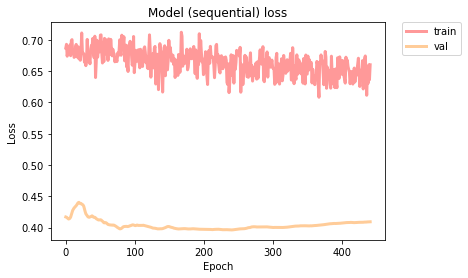

Epoch 1/1000
2/2 - 0s - loss: 0.6545 - mae: 0.4465 - val_loss: 0.4051 - val_mae: 0.2667
Epoch 2/1000
2/2 - 0s - loss: 0.6670 - mae: 0.4598 - val_loss: 0.4052 - val_mae: 0.2666
Epoch 3/1000
2/2 - 0s - loss: 0.6671 - mae: 0.4615 - val_loss: 0.4052 - val_mae: 0.2666
Epoch 4/1000
2/2 - 0s - loss: 0.6746 - mae: 0.4673 - val_loss: 0.4055 - val_mae: 0.2663
Epoch 5/1000
2/2 - 0s - loss: 0.6690 - mae: 0.4636 - val_loss: 0.4057 - val_mae: 0.2662
Epoch 6/1000
2/2 - 0s - loss: 0.6525 - mae: 0.4454 - val_loss: 0.4060 - val_mae: 0.2662
Epoch 7/1000
2/2 - 0s - loss: 0.6555 - mae: 0.4529 - val_loss: 0.4063 - val_mae: 0.2661
Epoch 8/1000
2/2 - 0s - loss: 0.6531 - mae: 0.4426 - val_loss: 0.4068 - val_mae: 0.2660
Epoch 9/1000
2/2 - 0s - loss: 0.6765 - mae: 0.4697 - val_loss: 0.4071 - val_mae: 0.2661
Epoch 10/1000
2/2 - 0s - loss: 0.6683 - mae: 0.4574 - val_loss: 0.4074 - val_mae: 0.2662
Epoch 11/1000
2/2 - 0s - loss: 0.6506 - mae: 0.4457 - val_loss: 0.4077 - val_mae: 0.2664
Epoch 12/1000
2/2 - 0s - loss:

2/2 - 0s - loss: 0.6633 - mae: 0.4529 - val_loss: 0.4210 - val_mae: 0.2692
Epoch 94/1000
2/2 - 0s - loss: 0.6538 - mae: 0.4494 - val_loss: 0.4212 - val_mae: 0.2694
Epoch 95/1000
2/2 - 0s - loss: 0.6481 - mae: 0.4449 - val_loss: 0.4215 - val_mae: 0.2696
Epoch 96/1000
2/2 - 0s - loss: 0.6320 - mae: 0.4326 - val_loss: 0.4218 - val_mae: 0.2698
Epoch 97/1000
2/2 - 0s - loss: 0.6556 - mae: 0.4514 - val_loss: 0.4220 - val_mae: 0.2698
Epoch 98/1000
2/2 - 0s - loss: 0.6704 - mae: 0.4549 - val_loss: 0.4222 - val_mae: 0.2699
Epoch 99/1000
2/2 - 0s - loss: 0.6461 - mae: 0.4437 - val_loss: 0.4223 - val_mae: 0.2699
Epoch 100/1000
2/2 - 0s - loss: 0.6630 - mae: 0.4559 - val_loss: 0.4225 - val_mae: 0.2700
Epoch 101/1000
2/2 - 0s - loss: 0.6652 - mae: 0.4569 - val_loss: 0.4227 - val_mae: 0.2701
Epoch 102/1000
2/2 - 0s - loss: 0.6618 - mae: 0.4518 - val_loss: 0.4229 - val_mae: 0.2703
Epoch 103/1000
2/2 - 0s - loss: 0.6657 - mae: 0.4592 - val_loss: 0.4230 - val_mae: 0.2704
Epoch 104/1000
2/2 - 0s - loss:

Epoch 185/1000
2/2 - 0s - loss: 0.6243 - mae: 0.4308 - val_loss: 0.4344 - val_mae: 0.2771
Epoch 186/1000
2/2 - 0s - loss: 0.6563 - mae: 0.4501 - val_loss: 0.4346 - val_mae: 0.2773
Epoch 187/1000
2/2 - 0s - loss: 0.6111 - mae: 0.4087 - val_loss: 0.4347 - val_mae: 0.2775
Epoch 188/1000
2/2 - 0s - loss: 0.6486 - mae: 0.4450 - val_loss: 0.4350 - val_mae: 0.2777
Epoch 189/1000
2/2 - 0s - loss: 0.6538 - mae: 0.4425 - val_loss: 0.4350 - val_mae: 0.2777
Epoch 190/1000
2/2 - 0s - loss: 0.6625 - mae: 0.4544 - val_loss: 0.4349 - val_mae: 0.2777
Epoch 191/1000
2/2 - 0s - loss: 0.6728 - mae: 0.4649 - val_loss: 0.4347 - val_mae: 0.2778
Epoch 192/1000
2/2 - 0s - loss: 0.6341 - mae: 0.4287 - val_loss: 0.4347 - val_mae: 0.2779
Epoch 193/1000
2/2 - 0s - loss: 0.6606 - mae: 0.4507 - val_loss: 0.4345 - val_mae: 0.2778
Epoch 194/1000
2/2 - 0s - loss: 0.6527 - mae: 0.4438 - val_loss: 0.4345 - val_mae: 0.2777
Epoch 195/1000
2/2 - 0s - loss: 0.6449 - mae: 0.4406 - val_loss: 0.4346 - val_mae: 0.2778
Epoch 196/

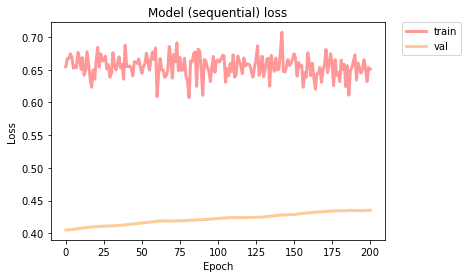

In [11]:
final_model_class = model_ts.fit_model(final_model, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

In [12]:
print(final_model_class)

Model name: sequential with executing time: 299.40551 seconds
	With fitness: 0.25429
	RMSE: 0.27084
	MAE: 0.20463


In [13]:
final_model = final_model_class.model
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 128)           66560     
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 128)           512       
_________________________________________________________________
dropout (Dropout)            (None, 24, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 128)           131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 128)           512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 32)            2

In [14]:
final_model = model_ts.fit_best_model(final_model, x, y, EPOCHS, BATCH_SIZE)

Epoch 1/1000
2/2 [==============================] - 6s 28ms/step - loss: 0.6493 - mae: 0.4485
Epoch 2/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.6632 - mae: 0.4630
Epoch 3/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.6557 - mae: 0.4553
Epoch 4/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.6688 - mae: 0.4639
Epoch 5/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.6612 - mae: 0.4586
Epoch 6/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.6484 - mae: 0.4507
Epoch 7/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.6732 - mae: 0.4701
Epoch 8/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.6287 - mae: 0.4357
Epoch 9/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.6646 - mae: 0.4627
Epoch 10/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.6554 - mae: 0.4532
Epoch 11/1000
2/2 [==============================] - 0s 19m

2/2 [==============================] - 0s 21ms/step - loss: 0.5876 - mae: 0.4087
Epoch 88/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.5930 - mae: 0.4069
Epoch 89/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.5897 - mae: 0.3997
Epoch 90/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.5989 - mae: 0.4095
Epoch 91/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.5904 - mae: 0.4049
Epoch 92/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.5772 - mae: 0.3967
Epoch 93/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.5706 - mae: 0.3900
Epoch 94/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.5733 - mae: 0.3917
Epoch 95/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.5876 - mae: 0.4029
Epoch 96/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.6036 - mae: 0.4155
Epoch 97/1000
2/2 [==============================] - 0s 20ms/ste

2/2 [==============================] - 0s 21ms/step - loss: 0.5379 - mae: 0.3663
Epoch 173/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.5014 - mae: 0.3444
Epoch 174/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.5356 - mae: 0.3593
Epoch 175/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.5210 - mae: 0.3557
Epoch 176/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.5386 - mae: 0.3631
Epoch 177/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.5016 - mae: 0.3384
Epoch 178/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.5281 - mae: 0.3584
Epoch 179/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.5164 - mae: 0.3472
Epoch 180/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.5416 - mae: 0.3638
Epoch 181/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.5328 - mae: 0.3597
Epoch 182/1000
2/2 [==============================] - 0

2/2 [==============================] - 0s 18ms/step - loss: 0.4718 - mae: 0.3188
Epoch 258/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.4725 - mae: 0.3173
Epoch 259/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.4839 - mae: 0.3243
Epoch 260/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.4617 - mae: 0.3063
Epoch 261/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.4650 - mae: 0.3116
Epoch 262/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.4691 - mae: 0.3118
Epoch 263/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.4757 - mae: 0.3151
Epoch 264/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.4606 - mae: 0.3116
Epoch 265/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.4637 - mae: 0.3087
Epoch 266/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.4615 - mae: 0.3107
Epoch 267/1000
2/2 [==============================] - 0

2/2 [==============================] - 0s 23ms/step - loss: 0.4488 - mae: 0.2969
Epoch 343/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.4397 - mae: 0.2936
Epoch 344/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.4314 - mae: 0.2837
Epoch 345/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.4531 - mae: 0.3003
Epoch 346/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.4295 - mae: 0.2830
Epoch 347/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.4363 - mae: 0.2887
Epoch 348/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.4259 - mae: 0.2864
Epoch 349/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.4366 - mae: 0.2861
Epoch 350/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.4431 - mae: 0.2956
Epoch 351/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.4210 - mae: 0.2865
Epoch 352/1000
2/2 [==============================] - 0

2/2 [==============================] - 0s 23ms/step - loss: 0.4064 - mae: 0.2692
Epoch 428/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.4021 - mae: 0.2660
Epoch 429/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.3965 - mae: 0.2683
Epoch 430/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.3940 - mae: 0.2625
Epoch 431/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.3844 - mae: 0.2539
Epoch 432/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.4041 - mae: 0.2688
Epoch 433/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.4075 - mae: 0.2709
Epoch 434/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3816 - mae: 0.2510
Epoch 435/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.4179 - mae: 0.2792
Epoch 436/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.4079 - mae: 0.2617
Epoch 437/1000
2/2 [==============================] - 0

2/2 [==============================] - 0s 23ms/step - loss: 0.3743 - mae: 0.2478
Epoch 513/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.3662 - mae: 0.2468
Epoch 514/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.3809 - mae: 0.2554
Epoch 515/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.3769 - mae: 0.2490
Epoch 516/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.3778 - mae: 0.2569
Epoch 517/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.3879 - mae: 0.2625
Epoch 518/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.3593 - mae: 0.2471
Epoch 519/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.3731 - mae: 0.2500
Epoch 520/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.3785 - mae: 0.2535
Epoch 521/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.3821 - mae: 0.2502
Epoch 522/1000
2/2 [==============================] - 0

2/2 [==============================] - 0s 18ms/step - loss: 0.3666 - mae: 0.2439
Epoch 598/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.3443 - mae: 0.2305
Epoch 599/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3695 - mae: 0.2481
Epoch 600/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3472 - mae: 0.2307
Epoch 601/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.3371 - mae: 0.2269
Epoch 602/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.3457 - mae: 0.2294
Epoch 603/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3502 - mae: 0.2341
Epoch 604/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3414 - mae: 0.2343
Epoch 605/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3551 - mae: 0.2381
Epoch 606/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3429 - mae: 0.2327
Epoch 607/1000
2/2 [==============================] - 0

2/2 [==============================] - 0s 19ms/step - loss: 0.3301 - mae: 0.2230
Epoch 683/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3315 - mae: 0.2246
Epoch 684/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3284 - mae: 0.2225
Epoch 685/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3258 - mae: 0.2248
Epoch 686/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.3391 - mae: 0.2266
Epoch 687/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3147 - mae: 0.2184
Epoch 688/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3331 - mae: 0.2221
Epoch 689/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3361 - mae: 0.2265
Epoch 690/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.3296 - mae: 0.2234
Epoch 691/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.3294 - mae: 0.2172
Epoch 692/1000
2/2 [==============================] - 0

2/2 [==============================] - 0s 18ms/step - loss: 0.3076 - mae: 0.2117
Epoch 768/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.3168 - mae: 0.2116
Epoch 769/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.3173 - mae: 0.2152
Epoch 770/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.3073 - mae: 0.2052
Epoch 771/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.3029 - mae: 0.2050
Epoch 772/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.3264 - mae: 0.2166
Epoch 773/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.3026 - mae: 0.2091
Epoch 774/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.3113 - mae: 0.2065
Epoch 775/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.3059 - mae: 0.2081
Epoch 776/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.3105 - mae: 0.2096
Epoch 777/1000
2/2 [==============================] - 0

2/2 [==============================] - 0s 13ms/step - loss: 0.3058 - mae: 0.2072
Epoch 853/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.3212 - mae: 0.2163
Epoch 854/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.3150 - mae: 0.2089
Epoch 855/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3025 - mae: 0.1987
Epoch 856/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3098 - mae: 0.2063
Epoch 857/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.3062 - mae: 0.2059
Epoch 858/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.3115 - mae: 0.2049
Epoch 859/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3002 - mae: 0.2056
Epoch 860/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2996 - mae: 0.2050
Epoch 861/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.3072 - mae: 0.2035
Epoch 862/1000
2/2 [==============================] - 0

2/2 [==============================] - 0s 26ms/step - loss: 0.3050 - mae: 0.2005
Epoch 938/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.2759 - mae: 0.1889
Epoch 939/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.3073 - mae: 0.2021
Epoch 940/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.2907 - mae: 0.1927
Epoch 941/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.2984 - mae: 0.2007
Epoch 942/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.2964 - mae: 0.1972
Epoch 943/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.2842 - mae: 0.1915
Epoch 944/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.2925 - mae: 0.1964
Epoch 945/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.2868 - mae: 0.1926
Epoch 946/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.2982 - mae: 0.1956
Epoch 947/1000
2/2 [==============================] - 0

Real data: [  20.    9.   14.   14.   40.  189. 1252.  597.  169.  192.  201.  259.
  304.  389.  498.  704.  621.  318.  102.   62.   42.   53.   39.   28.]
Forecasting values: [91, 88, 90, 90, 97, 160, 1194, 862, 149, 162, 167, 209, 253, 373, 617, 1031, 910, 269, 118, 104, 98, 101, 97, 93]


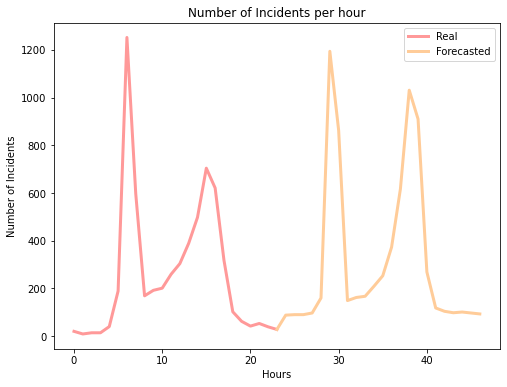

In [15]:
# Recursive Multi-step Forecast
forecasts, number_roads_forecast, yhat_inf, yhat_sup = model_ts.forecast(final_model, incidents, scaler_target, 
                              TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

model_ts.plot_prediction(incidents, forecasts, scaler_target)

In [16]:
results_table = pd.DataFrame(columns = ['Incidentes reais', 'Incidentes nas proximas 24h'])

list1 = list(scaler_target.inverse_transform([incidents.values[-TIMESTEPS:, -1]])[0])
list2 = forecasts

for i in range(len(list1)):
    df = pd.DataFrame([[round(list1[i]), round(list2[i])]], 
                      columns = ['Incidentes reais', 'Incidentes nas proximas 24h'])
    results_table = results_table.append(df)
    
results_table.to_csv('./results_table_sem_24h.csv', sep = ',', index = False)

# Sem as últimas 24h

Real data (first 24h): [  15.    8.    8.   18.   26.  150. 1001.  461.  142.  143.  162.  160.
  213.  206.  328.  504.  448.  245.   89.   49.   48.   32.   19.   20.] 

Real data (second 24h): [  20.    9.   14.   14.   40.  189. 1252.  597.  169.  192.  201.  259.
  304.  389.  498.  704.  621.  318.  102.   62.   42.   53.   39.   28.]
Forecasting values: [90, 88, 88, 91, 93, 139, 1168, 524, 135, 136, 145, 144, 175, 170, 281, 633, 493, 198, 113, 100, 99, 95, 91, 91]


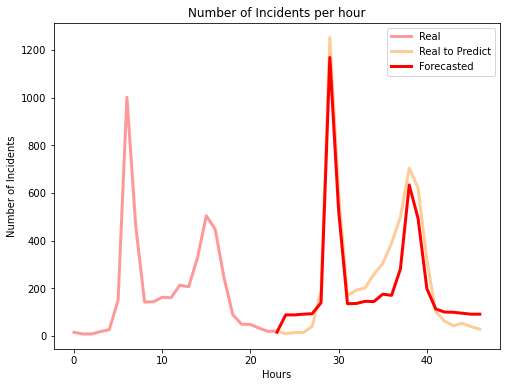

In [17]:
# Recursive Multi-step Forecast
forecasts, number_roads_forecast, yhat_inf, yhat_sup = model_ts.forecast(final_model, incidents[:-24], scaler_target, 
                              TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

model_ts.plot_prediction_evaluate(incidents, forecasts, scaler_target)

In [18]:
results_table = pd.DataFrame(columns = ['Incidentes reais', 'Incidentes reais a prever', 'Incidentes previstos'])

list1 = list(scaler_target.inverse_transform([incidents.values[-TIMESTEPS*2:-TIMESTEPS, -1]])[0])
list2 = list(scaler_target.inverse_transform([incidents.values[-TIMESTEPS:, -1]])[0])
list3 = forecasts

for i in range(len(list1)):
    df = pd.DataFrame([[round(list1[i]), round(list2[i]), round(list3[i])]],
                      columns = ['Incidentes reais', 'Incidentes reais a prever', 'Incidentes previstos'])
    results_table = results_table.append(df)
    
results_table.to_csv('./results_table_compare_24h.csv', sep = ',', index = False)

# Previsão do dia anterior

Real data (first 24h): [ 11.   9.   6.  10.  38. 124. 861. 484. 125. 130. 145. 215. 254. 207.
 218. 365. 389. 185.  55.  47.  50.  26.  16.  23.] 

Real data (second 24h): [  15.    8.    8.   18.   26.  150. 1001.  461.  142.  143.  162.  160.
  213.  206.  328.  504.  448.  245.   89.   49.   48.   32.   19.   20.]
Forecasting values: [89, 88, 88, 89, 96, 127, 1133, 581, 128, 130, 137, 176, 205, 171, 178, 333, 373, 158, 102, 99, 100, 93, 90, 92]


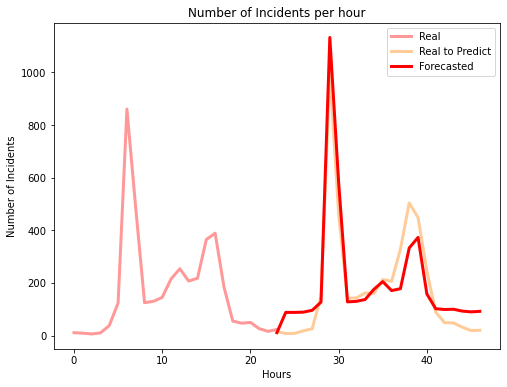

In [19]:
# Recursive Multi-step Forecast
forecasts, number_roads_forecast, yhat_inf, yhat_sup = model_ts.forecast(final_model, incidents[:-48], scaler_target, 
                              TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

model_ts.plot_prediction_evaluate(incidents[:-24], forecasts, scaler_target)